## Project Milestone 2
# Modern Times: Rise of Technology in Cinema

This is a python notebook containing the main code for the Applied Data Analysis project. Please refer to the README.md for an overview of the project.

## Table of contents:
* [Imports](#minusoneth)
* [Data loading](#zeroeth)
    * [Data augmentation](#zeroeth_a)
* [Exploratory data analysis](#second)
    * [Duplicate data](#second_b)
    * [Missing data](#second_a)
    * [Data visualisation](#second_c)
        * [Movie releases](#second_c1)
        * [Genre distributions](#second_c2)
        * [Movie reviews](#second_c3)
* [Data preprocessing](#first)
* [Focus : Technology in real life](#third)
    * [Lost movies](#third_a)
    * [Silent films & black and white films](#third_b)
    * [Special effects](#third_c)
* [Focus : Technology in movies](#fourth)
    * [Movies about technology](#fourth_a)
        * [Science Fiction & Fantasy](#fourth_a1)
        * [Keyphrase analysis](#fourth_a2)
        * [Historical events](#fourth_a3)
    * [Sentiment analysis](#fourth_b)
* [Next steps](#fifth)


## Imports <a class="anchor" id="minusoneth"></a>

We list the packages used by the project.

* [pandas](https://pandas.pydata.org/) - data handling
* [numpy](https://numpy.org/) - array math
* [seaborn](https://seaborn.pydata.org/) - visualisation
* [matplotlib](https://matplotlib.org/) - visualisation

In [1]:
# Imports
import os
import nltk
import numpy as np
import pandas as pd
import scipy as scp
import seaborn as sns
from tqdm import tqdm
from openai import OpenAI
from textblob import TextBlob
from collections import Counter
from matplotlib import pyplot as plt
from langdetect import detect, DetectorFactory, LangDetectException
from transformers import pipeline
import spacy

# Specific function
from scipy.stats import bootstrap
from IPython.display import clear_output, display
from concurrent.futures import ThreadPoolExecutor, as_completed
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter, defaultdict
import re
from scipy.stats import ttest_rel
from plotly.subplots import make_subplots
import ast
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

# Personal helper code
from helpers import *
from actors_career_arc import release_by_genre, plot_release_by_genre, actors_by_genre, plot_distrib_actors_by_genre

# Language datasets
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

2023-12-22 19:15:28.926593: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 19:15:28.950669: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 19:15:28.950699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 19:15:28.950716: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 19:15:28.956360: I tensorflow/core/platform/cpu_feature_g

True

## Data Loading <a class="anchor" id="zeroeth"></a>

We employ `load_data_with_columns` to read data from the following files as dataframes with named columns. 
* `character.metadata.tsv`
* `movie.metadata.tsv`
* `plot_summaries.txt`

The column names are listed in `column_names.txt`. Additionally, some date fields are immediately parsed with `date_to_float`. We use floats rather than ints to conserve NaN values.

Further datasets are loaded later in the notebook when they are needed.

In [2]:
# Loading the data
DATAFOLDER = '../data/'

# Character metadata
character_metadata = load_data_with_columns(DATAFOLDER, 'character.metadata.tsv')
date_to_float(character_metadata, 'movie_release_date')
date_to_float(character_metadata, 'actor_birth_date')

# Movie metadata
movie_metadata = load_data_with_columns(DATAFOLDER, 'movie.metadata.tsv')
date_to_float(movie_metadata, 'movie_release_date')

# Plot summaries
plot_summaries = load_data_with_columns(DATAFOLDER, 'plot_summaries.txt')

### Data augmentation <a class="anchor" id="zeroeth_a"></a>

Just counting the null values reveals a lot of missing values in  `movie_metadata`

In [3]:
# Sum up null values per column
print("Column\t\t\tNull count:\n---------------------------")
print(movie_metadata.isnull().sum())

Column			Null count:
---------------------------
movie_wikipedia_id        0
movie_freebase_id         0
movie_name                0
movie_release_date     6902
box_office            73340
runtime               20450
languages                 0
countries                 0
genres                    0
dtype: int64


We try to recover as many as possible by web-scraping. We focus on `movie_release_date` and  `box_office`.

First we import a map from Freebase to IMDb IDs from wikidata.

In [4]:
# Load map from Freebase ID to IMDb ID
links_free_imdb = pd.read_table(DATAFOLDER + '/wikidata_freebase_imdb.tsv')[['Freebase_ID', 'IMDb_ID']]

# Rename columns to our convention
links_free_imdb.rename(columns={'Freebase_ID': 'movie_freebase_id', 'IMDb_ID': 'movie_imdb_id'}, inplace=True)

# Drop duplicates and assert no null values
links_free_imdb = links_free_imdb.drop_duplicates(subset='movie_freebase_id')
assert(all(links_free_imdb.isnull().sum()== 0))
display(links_free_imdb)

,movie_freebase_id,movie_imdb_id
0,/m/0hgqwpj,tt1675434
1,/m/027zfqr,tt0065035
2,/m/083whx,tt0120948
3,/m/0m_tj,tt0050083
4,/m/0jzsdw1,tt4168940
...,...,...
157602,/m/012nmg7z,tt1411844
157603,/m/02qg338,tt0300877
157604,/m/0_qfb7q,tt10923898
157605,/m/027yzkv,tt2006485


In [5]:
# Enrich the movies dataframe with imbd_ID
movies_with_imdb_id = pd.merge(movie_metadata, links_free_imdb, on='movie_freebase_id', how='left').copy()

In [6]:
# Identifying movies with missing release dates
missing_release_date = movies_with_imdb_id[movies_with_imdb_id['movie_release_date'].isnull()][['movie_wikipedia_id', 'movie_release_date']].copy()
display(missing_release_date)

,movie_wikipedia_id,movie_release_date
15,11250635,NaN
74,31137877,NaN
81,27374355,NaN
103,29766415,NaN
120,28415406,NaN
...,...,...
81690,35758766,NaN
81692,26219108,NaN
81711,31422084,NaN
81715,29449643,NaN


In [7]:
# Identifying movies with missing box offices
missing_box_office = movies_with_imdb_id[movies_with_imdb_id['box_office'].isnull()][['movie_wikipedia_id', 'box_office', 'movie_imdb_id']].copy()
display(missing_box_office)

,movie_wikipedia_id,box_office,movie_imdb_id
1,3196793,NaN,tt0245916
2,28463795,NaN,tt0094806
3,9363483,NaN,tt0094320
4,261236,NaN,tt0083949
5,13696889,NaN,tt0002894
...,...,...,...
81736,35228177,NaN,tt1816585
81737,34980460,NaN,tt1606259
81738,9971909,NaN,tt0362411
81739,913762,NaN,tt0113726


 For release years, we scrape wikipedia pages with the following URL structure: "https://en.wikipedia.org/wiki?curid={wikipedia_id}".  
 For box office revenues, We scrape the website "https://www.boxofficemojo.com/" which uses IMDb IDs. 

In [8]:
# Activate this to run web-scraping
SCRATCH_SCRAPE = False
if SCRATCH_SCRAPE:

    # Scrape Wikipedia for release years
    for index, row in tqdm(missing_release_date.iterrows(), total=missing_release_date.shape[0]):

        # Find movie release year on Wikipedia
        wikipedia_id = row['movie_wikipedia_id']
        release_year = get_movie_release_year(wikipedia_id)
        
        # If available, update the movie dataset
        if release_year:
            missing_release_date.at[index, 'movie_release_date'] = release_year

    # Save results to .csv
    missing_release_date = missing_release_date.dropna(subset='movie_release_date')
    missing_release_date.to_csv(DATAFOLDER + 'missing_release_date.csv', index=False) 

    
    # Scrape BoxOfficeMojo for box office revenues
    imdb_ids = missing_box_office['movie_imdb_id'].tolist() 
    with ThreadPoolExecutor(max_workers=10) as executor:  # Use ThreadPoolExecutor for parallel processing

        # Create scrapers that run asynchronously
        future_to_imdb_id = {executor.submit(scrape_box_office, imdb_id): imdb_id for imdb_id in imdb_ids}
        for future in tqdm(as_completed(future_to_imdb_id), total=len(imdb_ids)):
            imdb_id = future_to_imdb_id[future]
            try:
                box_office = future.result()
                if box_office:
                    missing_box_office.loc[missing_box_office['movie_imdb_id'] == imdb_id, 'box_office'] = box_office
            except Exception as e:
                print(f"Error processing {imdb_id}: {e}")

    # Save results to .csv
    missing_box_office = missing_box_office.dropna(subset='box_office')
    missing_box_office.to_csv(DATAFOLDER + 'missing_box_office.csv', index=False) 

# Otherwise load previous results
else:
    missing_release_date = pd.read_csv(DATAFOLDER + '/missing_release_date.csv')
    missing_box_office = pd.read_csv(DATAFOLDER + '/missing_box_office.csv')

    # Parse money-strings ($49,000) as floats
    missing_box_office['box_office'] = missing_box_office['box_office'].str.replace('$', '').str.replace(',', '').astype(float)

Now `missing_release_date` and `missing_box_office` contain values scraped off the internet, if they were available.

In [9]:
# 4492 release dates uncovered
display(missing_release_date)

,movie_wikipedia_id,movie_release_date
0,11250635,1941.0
1,31137877,1927.0
2,27374355,1977.0
3,29766415,1945.0
4,28415406,2007.0
...,...,...
4487,35758766,2000.0
4488,26219108,1920.0
4489,31422084,1996.0
4490,29449643,2011.0


In [10]:
# 6672 box offices uncovered
display(missing_box_office)

,movie_wikipedia_id,box_office,movie_imdb_id
0,21926710,69171.0,tt0892904
1,25960460,6718.0,tt0166158
2,13281430,344938.0,tt0843287
3,21449578,50000.0,tt0116480
4,24761154,449473.0,tt1065099
...,...,...,...
6767,1673588,3677209.0,tt0087004
6768,3868432,70277.0,tt0372937
6769,32468537,12859418.0,tt0459759
6770,34980460,24655.0,tt1606259


So we can merge the found data into the movies dataframe.

In [11]:
# Merge the two dataframes on 'wikipedia_id' while keeping all records from movies_metadata
movies_recovered = pd.merge(movies_with_imdb_id, missing_box_office[['movie_wikipedia_id', 'box_office']], on='movie_wikipedia_id', how='left', suffixes=('', '_missing'))

# Where box_office_missing is not NaN, update the box_office in movies_metadata
movies_recovered['box_office'] = movies_recovered['box_office_missing'].where(movies_recovered['box_office_missing'].notna(), movies_recovered['box_office'])

# Drop the temporary 'box_office_missing' column
movies_recovered.drop(columns=['box_office_missing'], inplace=True)

# Merge the two dataframes on 'wikipedia_id' while keeping all records from movies_metadata
movies_recovered = pd.merge(movies_recovered, missing_release_date[['movie_wikipedia_id', 'movie_release_date']], on='movie_wikipedia_id', how='left', suffixes=('', '_missing'))

# Where box_office_missing is not NaN, update the box_office in movies_metadata
movies_recovered['movie_release_date'] = movies_recovered['movie_release_date_missing'].where(movies_recovered['movie_release_date_missing'].notna(), movies_recovered['movie_release_date'])

# Drop the temporary 'box_office_missing' column
movies_recovered.drop(columns=['movie_release_date_missing'], inplace=True)

Notice how the number of null-values for `box_office` and `movie_release_date` are smaller.

In [12]:
# Sum up null values per column
print("Column\t\t\tNull count:\n---------------------------")
print(movies_recovered.isnull().sum())

Column			Null count:
---------------------------
movie_wikipedia_id        0
movie_freebase_id         0
movie_name                0
movie_release_date     2410
box_office            66568
runtime               20450
languages                 0
countries                 0
genres                    0
movie_imdb_id          7986
dtype: int64


## Exploratory data analysis <a class="anchor" id="second"></a>

We go ahead and look at the data, at first the number of entries, and we see that it is manageable.

In [13]:
# Display character metadata
display(character_metadata)
print("Number of entries: ", np.prod(character_metadata.shape))

,movie_wikipedia_id,movie_freebase_id,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_map_id,character_freebase_id,actor_freebase_id
0,975900,/m/03vyhn,2001.0,Akooshay,1958.0,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001.0,Lieutenant Melanie Ballard,1974.0,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001.0,Desolation Williams,1969.0,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001.0,Sgt Jericho Butler,1967.0,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001.0,Bashira Kincaid,1977.0,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992.0,Elensh,1970.0,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992.0,Hibiki,1965.0,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957.0,NaN,1941.0,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957.0,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


Number of entries:  5858697


In [14]:
# Display movie metadata
display(movies_recovered)
print("Number of entries: ", np.prod(movies_recovered.shape))

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres,movie_imdb_id
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",tt0245916
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],tt0083949
...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011.0,NaN,120.0,[English Language],[United States of America],[Drama],tt1816585
81737,34980460,/m/0g4pl34,Knuckle,2011.0,24655.0,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259
81738,9971909,/m/02pygw1,Another Nice Mess,1972.0,NaN,66.0,[English Language],[United States of America],"[Satire, Comedy]",tt0362411
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992.0,NaN,150.0,[Japanese Language],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...",tt0113726


Number of entries:  817410


In [15]:
# Display plot summaries
display(plot_summaries)
print("Number of entries: ", np.prod(plot_summaries.shape))

,movie_wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


Number of entries:  84606


Remark: There appear to be more rows in `movies_recovered` than in plot_summaries. This can be due to duplicate or missing data.

### Duplicate data <a class="anchor" id="second_b"></a>

We show the following: 
1. The wikipedia IDs are unique in `movies_recovered` and `plot_summaries`.
2. There are different movies with exactly the same plot summary text, due to different film industries or remakes of the same movie.

In [16]:
# The wikipedia_id's are unique in both tables.
assert(movies_recovered['movie_wikipedia_id'].is_unique)
assert(plot_summaries['movie_wikipedia_id'].is_unique)

In [17]:
# Duplicate plot texts
duplicated_plots = plot_summaries[plot_summaries['plot'].duplicated(keep=False)]
print("There are {:d} plot summaries that appear more than once.".format(len(duplicated_plots['plot'].unique())))

There are 5 plot summaries that appear more than once.


In [18]:
# Left-merge movie metadata with plots. This disregards the 99 plots with no metadata
movies_with_plots = movies_recovered.merge(plot_summaries, how='left')

# There are movies with different titles but identical plots.
movies_with_plots.set_index('movie_wikipedia_id').loc[duplicated_plots['movie_wikipedia_id']].groupby('plot')['movie_name'].unique().reset_index()

,plot,movie_name
0,A woman is thrown out of her home by her jealo...,"[Madame X, The Trial of Madame X]"
1,An orphan Raghav turns into a ruthless contrac...,"[Antham, Drohi]"
2,"As the American Civil War begins, Ned Burton l...",[The Warrens of Virginia]
3,Raja was adopted by a criminal don at a very ...,[Amar Deep]
4,Taking a step aside from the usual serious dra...,"[Andhamaina Anubhavam, Ninaithale Inikkum]"


What can we know about these movies whose plots appear multiple times?

In [19]:
# Print data about those movies who share a plot with another movie.
movie_metadata[movie_metadata['movie_wikipedia_id'].isin(duplicated_plots['movie_wikipedia_id'])][['movie_name', 'movie_release_date', 'languages', 'countries']].sort_values(by='movie_name')

,movie_name,movie_release_date,languages,countries
22185,Amar Deep,1979.0,[Hindi Language],[India]
32255,Amar Deep,NaN,[Hindi Language],[]
59148,Andhamaina Anubhavam,1979.0,[Telugu language],[India]
67464,Antham,1992.0,[Telugu language],[India]
28621,Drohi,1992.0,[Hindi Language],[India]
18993,Madame X,1916.0,"[Silent film, English Language]",[United States of America]
49381,Madame X,1920.0,"[Silent film, English Language]",[United States of America]
57569,Madame X,1954.0,[Greek Language],[Greece]
65014,Madame X,1981.0,[English Language],[United States of America]
59142,Ninaithale Inikkum,1979.0,[Tamil Language],[India]


**We note the following**:
1. *Andhamaina Anubhavam* / *Ninaithale Inikkum* are the Telugu and Tamil names for the same movie. 
2. *Antham* / *Drohi* are the Telugu and Hindi names for the same movie.
3. There are multiple movie adaptations of the play *(The Trial of) Madame X*. 
4. There is a "lost" 1924 version of the movie The Warrens of Virginia, with the same plot, but it appears in this dataset.
5. The movie *Amar Deep* appearing twice appears to simply be a dataset error.

### Missing data <a class="anchor" id="second_a"></a>

We show the following:
1. The wikipedia IDs in `plot_summaries` are not a subset of those in `movies_recovered`, as there are 99 summaries with no associated metadata. 
2. The percentage of missing plot summaries per decade **decreases**, while the absolute number of missing plot summaries **increases**.

In [20]:
# Summaries with no metadata
movie_metadata_ids = movies_recovered['movie_wikipedia_id'].to_list()
plot_summaries_ids = plot_summaries['movie_wikipedia_id'].to_list()
plot_no_metadata_ids = [id for id in plot_summaries_ids if id not in movie_metadata_ids]

# Number of summaries with no metadata.
print("There are {:d} plot summaries with no associated metadata".format(len(plot_no_metadata_ids)))
plot_summaries.set_index('movie_wikipedia_id').loc[plot_no_metadata_ids].reset_index()

There are 99 plot summaries with no associated metadata


,movie_wikipedia_id,plot
0,2862137,Sathyanarayan Murthy is a rough but kind man ...
1,33334420,{{more plot}} Mural tells the story of Zhu Xia...
2,16758721,"The story is about a young man “Tony”, a 25 ye..."
3,23217064,"Years before the events of the first film, Lo..."
4,2746943,"A young 16-year-old girl, Zhu Ying Tai, manage..."
...,...,...
94,35607003,Parisian Marion is living in New York with her...
95,32942181,"Rajat , Nishant ""Liquid"" Agarwal and Vikrant ..."
96,133671,Gerry Conlon is shown in Belfast stripping le...
97,34076714,"After a hit gone wrong, Nikita, an exiled Russ..."


What is the percentage of missing plot summary data per decade? First we group into decades.

In [21]:
# Group into decades
movies_with_decades = bin_into_decades(movies_with_plots, 'movie_release_date')

Looking at the number of movies per decade reveals an error with the 2010 movie Turkish movie [Hunting Season](https://www.imdb.com/title/tt1668191/) marked as being made in the 1010s.

In [22]:
# Display the error
print("Value counts\n-----\n",movies_with_decades['movie_release_date_decade'].value_counts())
display(movies_with_decades.loc[62836])

Value counts
-----
 movie_release_date_decade
2000.0    20236
1990.0     9849
1980.0     7813
1970.0     7206
1960.0     6176
1950.0     6161
2010.0     5896
1930.0     5074
1940.0     4721
1920.0     3056
1910.0     2762
1900.0      209
1890.0      168
1880.0        2
2020.0        1
1010.0        1
Name: count, dtype: int64


movie_wikipedia_id                                                    29666067
movie_freebase_id                                                   /m/0fphzrf
movie_name                                                      Hunting Season
movie_release_date                                                      1010.0
box_office                                                          12160978.0
runtime                                                                  140.0
languages                                 [Turkish Language, English Language]
countries                                                             [Turkey]
genres                               [Crime Fiction, Mystery, Drama, Thriller]
movie_imdb_id                                                        tt1668191
plot                         Veteran homicide cop Ferman  and his hot-heade...
movie_release_date_decade                                               1010.0
Name: 62836, dtype: object

We correct the error manually.

In [23]:
# Correct the error.
movies_correct_dates = movies_with_decades.copy()
movies_correct_dates.loc[62836, 'movie_release_date'] = 2010
movies_correct_dates.loc[62836, 'movie_release_date_decade'] = 2010

We the movies group by decade and perform bootstrap estimation of the percentage of missing values with 95% confidence intervals.

In [24]:
# Bootstrap parameters
bootstrap_args = {'statistic' : percent_nans, 'n_resamples':100, 'confidence_level':0.95, 'alternative':'two-sided', 'method':'percentile'}

# Groupby decades
plots_by_decade = movies_correct_dates.groupby('movie_release_date_decade', observed=False, group_keys=True)['plot']

# Perform bootstrap estimation of missing plot summary data
intervals_by_decade = plots_by_decade.apply(lambda x: bootstrap((duplicate_singleton(x), ), **bootstrap_args).confidence_interval[:])

# Unpack intervals into dataframe
low_high_by_decade = expand_list_data(pd.DataFrame(intervals_by_decade).set_axis(['interval'],axis=1), 'interval', ['low', 'high']).copy()

# Put data together
missing_plots = pd.concat([pd.DataFrame({
    'mean':plots_by_decade.apply(percent_nans), 
    'count':plots_by_decade.apply(lambda x: x.isnull().sum())}), 
    low_high_by_decade], axis=1)

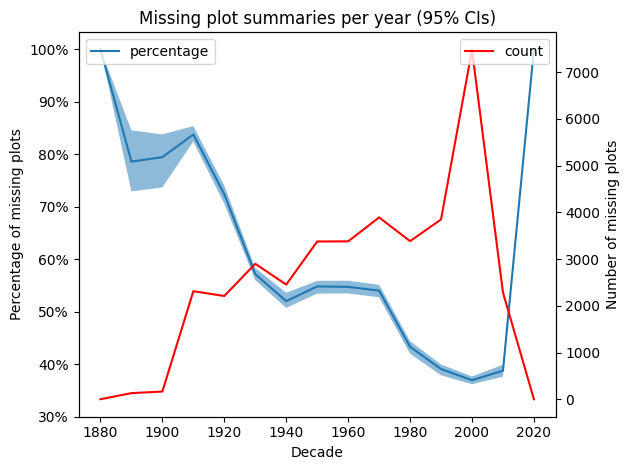

In [25]:
# Plot percentage and count
fig, ax1 = plt.subplots()
ax1.set_title(f"Missing plot summaries per year (95% CIs)")
ax1.set_xlabel("Decade")
ax1.set_ylabel("Percentage of missing plots")
plot_with_confidence(missing_plots, 'mean', 'percentage', ax1)
ax1.set_yticks(ticks=ax1.get_yticks()[:-1], labels=["{:.0f}%".format(p*100) for p in ax1.get_yticks()[:-1]])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of missing plots')
ax2.plot(missing_plots['count'], label = 'count', color='red')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

### Data visualisation  <a class="anchor" id="second_c"></a>

Let's visualize some quantities that can be for use in the following analysis and to have a look at the data.

#### **Movie releases** <a class="anchor" id="second_c1"></a>

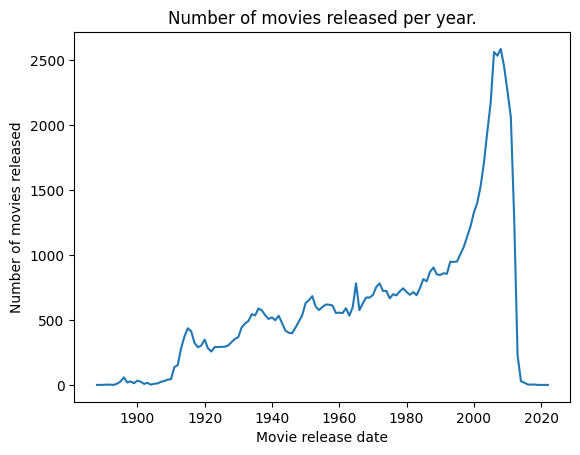

In [26]:
# Plot movie release count per year
plt.plot(movies_correct_dates['movie_release_date'].value_counts().sort_index())
plt.title("Number of movies released per year.")
plt.xlabel("Movie release date")
plt.ylabel("Number of movies released")
plt.show()

In [27]:
movies_genres = movies_correct_dates.explode('genres')

We note that the movie industry kicked off in the 1910's and then experienced exponential growth. 

#### **Genre distributions** <a class="anchor" id="second_c2"></a>

Let's have a look at the genre distribution, both *over all time* and *across time* for the main genres of interest

In [28]:
# Flatten the list of genres
all_genres = [genre for sublist in movies_correct_dates['genres'] for genre in sublist]

# Count the number of each genre 
genre_counts = pd.Series(all_genres).value_counts()
genre_counts

Drama                   34007
Comedy                  16349
Romance Film            10234
Black-and-white          9094
Action                   8798
                        ...  
Romantic thriller           1
Comdedy                     1
C-Movie                     1
Silhouette animation        1
Homoeroticism               1
Name: count, Length: 363, dtype: int64

We plot the top 30 genres of all time.

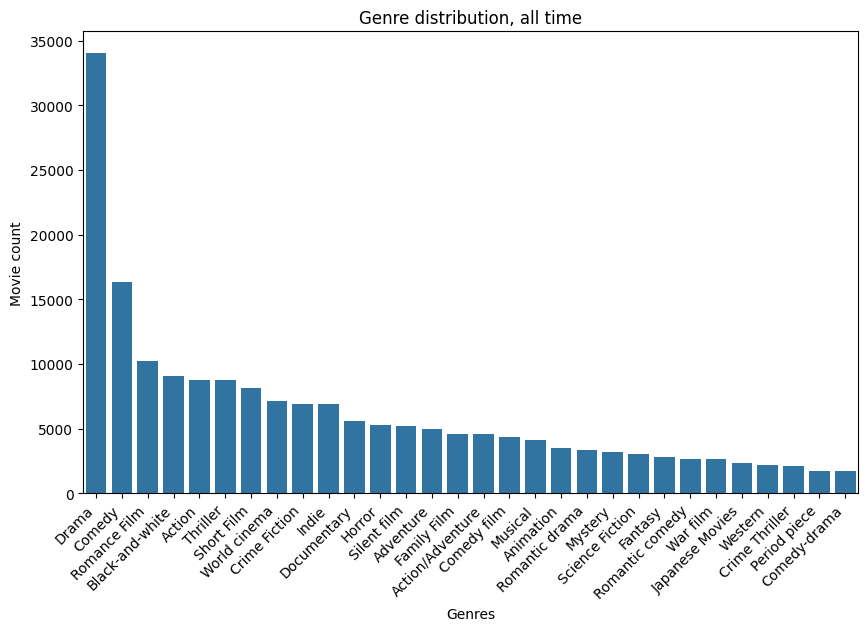

In [29]:
# Plot Genre Distribution
genres_top30 = genre_counts.nlargest(30)

plt.figure(figsize=(10, 6))  
sns.barplot(x=genres_top30.index, y=genres_top30.values)
plt.title('Genre distribution, all time')
plt.xlabel('Genres')
plt.ylabel('Movie count')
plt.xticks(rotation=45, ha='right')  
plt.show()

Drama, comedy and romance lead in the top 3. The genre of interest (see below) are included in the top 30 genres in the 363 long list of genre categories. Their number and presence is therefore non negligible.

Let's now look at the evolution in time of certain genre of interest. 
- Science Fiction: A genre with technology as a main theme.
- Fantasy: New technologies permits better rendering and thus popularity of the genre.
- Black and white & Silent Films: To look at the drop coming after the advent of colour and sound.
- War films: Wars are heavily shaped by technology and power, for example, the nuclear bomb.

In [30]:
# Group by genre and get value counts
genre_counts_per_year = movies_correct_dates.groupby('movie_release_date').apply(lambda x: pd.Series({
    'genre_counts': pd.Series([genre for sublist in x['genres'] for genre in sublist]).value_counts()
}))

# Genres of interest
interesting_genres = ['Science Fiction', 'Fantasy', 'Black-and-white', 'Silent film', 'War film']

# Expand value counts into multiple columns
genre_counts_per_year = genre_counts_per_year['genre_counts'].apply(lambda x: pd.Series({genre : x.get(genre, 0) for genre in interesting_genres}))

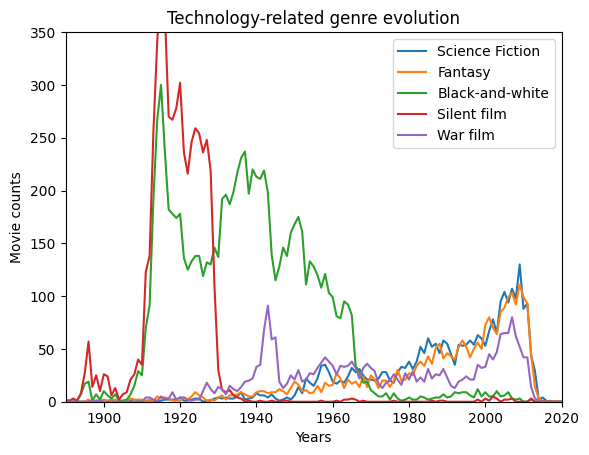

In [31]:
# Plot genre counts per year
for _, genre in enumerate(interesting_genres):
    plt.plot(genre_counts_per_year.index.to_numpy(), genre_counts_per_year[genre].to_numpy(), label = genre)

plt.xlabel("Years")
plt.ylabel("Movie counts")
plt.xlim(1890,2020)
plt.ylim(0,350)
plt.title("Technology-related genre evolution")
plt.legend()
plt.show()

While Black-and-white, as well as Silent films have a very different trend from the general one, SF and Fantasy are slowly growing genre. War films follow a similar trend - while being less popular and having a special peak after the 2nd World War.

To better visualize the growing popularity - or not - of SF and Fantasy and remove the confounder of a generally growing movie industry, let's make a proportion plot.

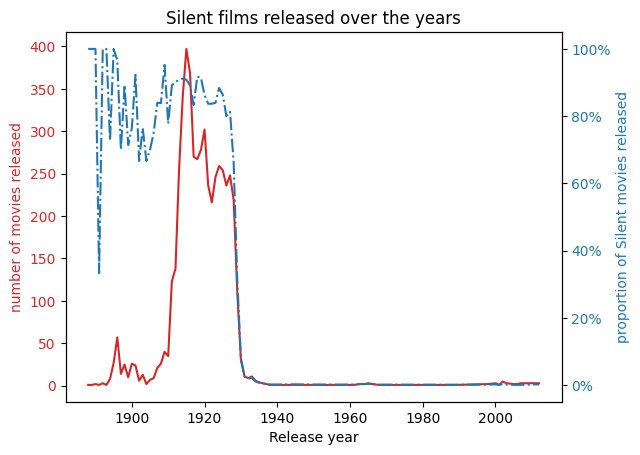

,frequency,total_nb_films
movie_release_date,,
1902.0,6,9
1900.0,26,34
1894.0,8,11
1909.0,40,42
1923.0,246,293


In [32]:
#Dataframe grouping Silent films by year and indicating the number of silent films relased, as well as the total number of films released in that year
mute_films, mute_films_by_year = release_by_genre(movies_correct_dates)
plot_release_by_genre(mute_films_by_year)

#Display resulting dataframe
display(mute_films_by_year.sample(5))

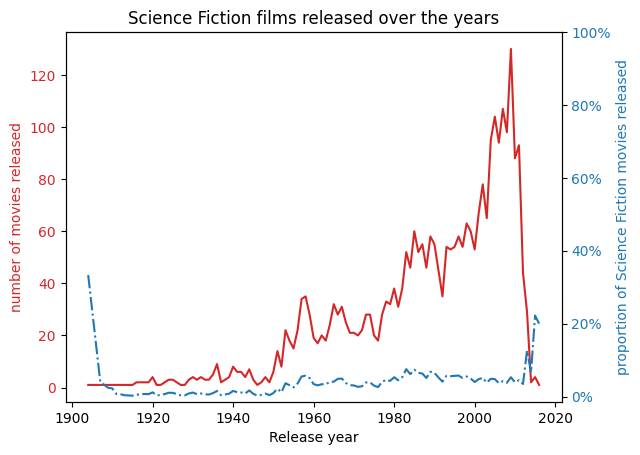

In [33]:
# Dataframe grouping genre films by year and indicating the number of genre films released, as well as the total number of films released in that year
sf_films, sf_films_by_year = release_by_genre(movies_correct_dates, 'Science Fiction')
sf_films_by_year = sf_films_by_year.drop(index = sf_films_by_year.index[0])

# Plot the proportion and number of movies released in time for genre
plot_release_by_genre(sf_films_by_year, 'Science Fiction')

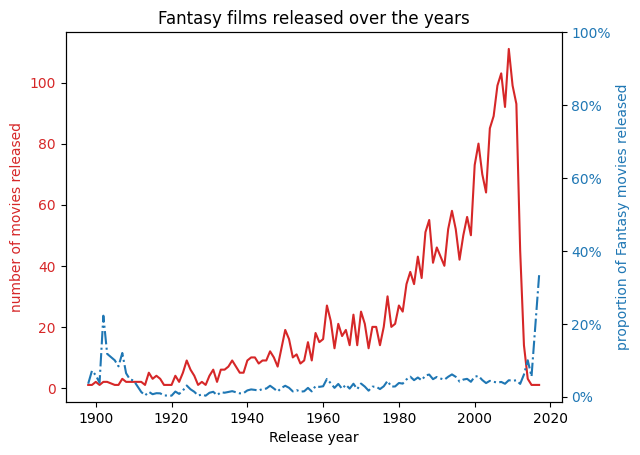

In [34]:
# Dataframe grouping genre films by year and indicating the number of genre films released, as well as the total number of films released in that year
fts_films, fts_films_by_year = release_by_genre(movies_correct_dates, 'Fantasy')
fts_films_by_year = fts_films_by_year.drop(index = fts_films_by_year.index[0])

# Plot the proportion and number of movies released in time for genre
plot_release_by_genre(fts_films_by_year, 'Fantasy')


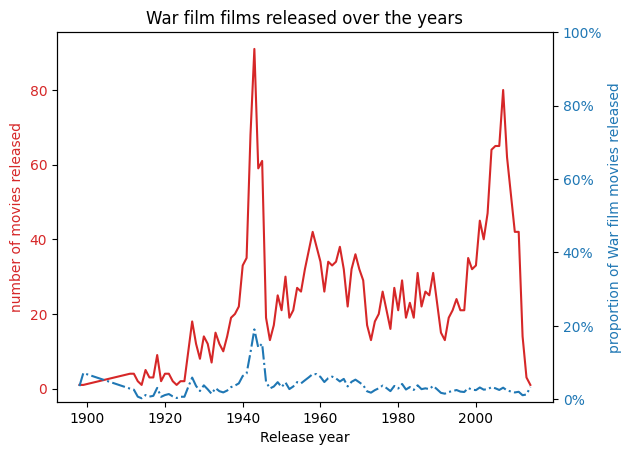

In [35]:
# Dataframe grouping genre films by year and indicating the number of genre films released, as well as the total number of films released in that year
wf_films, wf_films_by_year = release_by_genre(movies_correct_dates, 'War film')
wf_films_by_year = wf_films_by_year.drop(index = wf_films_by_year.index[0])

# Plot the proportion and number of movies released in time for genre
plot_release_by_genre(wf_films_by_year, 'War film')

- SF: Is proportionately almost not a growing field with time, but went a bit up in the 50's. There is a high proportion peak in the old days, but this can be explained by the small number of released movies: even only with one movie enterin the category, the proportion number severely goes up. 
- Fantasy: Similar trends can be observed. 
- War: There is still a very visible peak after the 40's, probably caused by the 2nd World War, an event so predominant in the culture that up to half of the movies released in the following years correspond to war films. The trend is nevertheless going down from the 60's to now.

For Black-and-White analysis, please look at the corresponding section. 

#### **Movie reviews** <a class="anchor" id="second_c3"></a>

For further analysis we use movie reviews from RottenTomatoes.

**NOTE** Please unzip `rotten_tomates_critic_reviews.zip` and extract to the same location. The file is too large to share over Github (>200Mb).

In [36]:
# Load reviews from Rotten Tomatoes
critic_reviews = pd.read_csv(DATAFOLDER + 'rotten_tomatoes_critic_reviews.csv')
critic_reviews = critic_reviews[['rotten_tomatoes_link', 'review_type', 'review_content', 'review_date']]
date_to_float(critic_reviews, 'review_date')

,rotten_tomatoes_link,review_type,review_content,review_date
0,m/0814255,Fresh,A fantasy adventure that fuses Greek mythology...,2010.0
1,m/0814255,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",2010.0
2,m/0814255,Fresh,With a top-notch cast and dazzling special eff...,2010.0
3,m/0814255,Fresh,Whether audiences will get behind The Lightnin...,2010.0
4,m/0814255,Rotten,What's really lacking in The Lightning Thief i...,2010.0
...,...,...,...,...
1130012,m/zulu_dawn,Rotten,NaN,2005.0
1130013,m/zulu_dawn,Fresh,"Seen today, it's not only a startling indictme...",2007.0
1130014,m/zulu_dawn,Fresh,A rousing visual spectacle that's a prequel of...,2010.0
1130015,m/zulu_dawn,Rotten,"A simple two-act story: Prelude to war, and th...",2011.0


Note that reviews may be written at much later than the movie release itself. This is for interesting understanding changing opinions.

In [37]:
# Filter for 'Fresh' reviews, which are reviews written within 5 years of the movie's release
fresh_reviews = critic_reviews[critic_reviews['review_type'] == 'Fresh']

# Calculate the percentage
percentage_fresh = (len(fresh_reviews) / len(critic_reviews)) * 100

print(f"Percentage of Fresh Reviews: {percentage_fresh:.2f}%")

Percentage of Fresh Reviews: 63.73%


We further obtain general movie data from Rotten Tomatoes.

In [38]:
# Load movie data from Rotten Tomatoes
rotten_tomatoes_movies = pd.read_csv(DATAFOLDER + '/rotten_tomatoes_movies.csv')
rotten_tomatoes_movies = rotten_tomatoes_movies[['rotten_tomatoes_link', 'movie_title', 'original_release_date']]
date_to_float(rotten_tomatoes_movies, 'original_release_date')

,rotten_tomatoes_link,movie_title,original_release_date
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,2010.0
1,m/0878835,Please Give,2010.0
2,m/10,10,1979.0
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),1957.0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea",1954.0
...,...,...,...
17707,m/zoot_suit,Zoot Suit,1981.0
17708,m/zootopia,Zootopia,2016.0
17709,m/zorba_the_greek,Zorba the Greek,1964.0
17710,m/zulu,Zulu,1964.0


We merge the reviews `critic_reviews` with the movie metadata `rotten_tomatoes_movies` from Rotten Tomatoes.

In [39]:
rt_movies_with_reviews = pd.merge(critic_reviews, rotten_tomatoes_movies, on=['rotten_tomatoes_link'], how='left')
display(rt_movies_with_reviews)

,rotten_tomatoes_link,review_type,review_content,review_date,movie_title,original_release_date
0,m/0814255,Fresh,A fantasy adventure that fuses Greek mythology...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
1,m/0814255,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
2,m/0814255,Fresh,With a top-notch cast and dazzling special eff...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
3,m/0814255,Fresh,Whether audiences will get behind The Lightnin...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
4,m/0814255,Rotten,What's really lacking in The Lightning Thief i...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
...,...,...,...,...,...,...
1130012,m/zulu_dawn,Rotten,NaN,2005.0,Zulu Dawn,1979.0
1130013,m/zulu_dawn,Fresh,"Seen today, it's not only a startling indictme...",2007.0,Zulu Dawn,1979.0
1130014,m/zulu_dawn,Fresh,A rousing visual spectacle that's a prequel of...,2010.0,Zulu Dawn,1979.0
1130015,m/zulu_dawn,Rotten,"A simple two-act story: Prelude to war, and th...",2011.0,Zulu Dawn,1979.0


Looking at the null values, we see lots under `review_content` and only a few under `original release date`.

In [40]:
print(rt_movies_with_reviews.isnull().sum())

rotten_tomatoes_link         0
review_type                  0
review_content           65806
review_date                  0
movie_title                130
original_release_date    23230
dtype: int64


What is the percentage of reviews with no textual content?

In [41]:
# Groupby year
reviews_by_year = rt_movies_with_reviews.groupby('original_release_date', observed=False, group_keys=True)['review_content']

# Perform bootstrap estimation of missing plot summary data
intervals_by_year = reviews_by_year.apply(lambda x: bootstrap((duplicate_singleton(x), ), **bootstrap_args).confidence_interval[:])

# Unpack intervals into dataframe
low_high_by_year = expand_list_data(pd.DataFrame(intervals_by_year).set_axis(['interval'],axis=1), 'interval', ['low', 'high']).copy()

# Put data together
missing_reviews = pd.concat([pd.DataFrame({
    'mean':reviews_by_year.apply(percent_nans), 
    'count':reviews_by_year.apply(lambda x: x.isnull().sum())}), 
    low_high_by_year], axis=1)

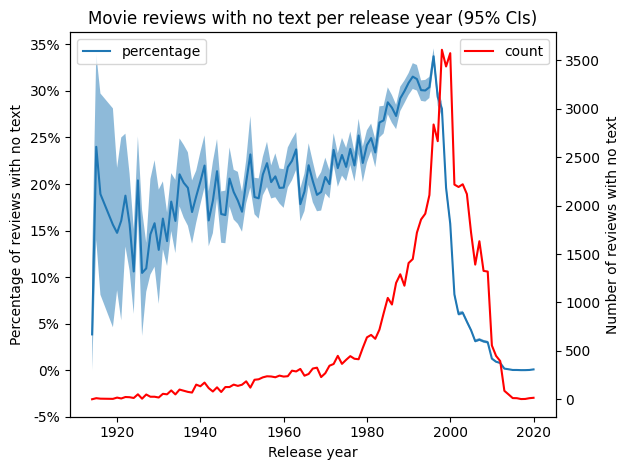

In [42]:
# Plot percentage and count
fig, ax1 = plt.subplots()
ax1.set_title(f"Movie reviews with no text per release year (95% CIs)")
ax1.set_xlabel("Release year")
ax1.set_ylabel("Percentage of reviews with no text")
plot_with_confidence(missing_reviews, 'mean', 'percentage', ax1)
ax1.set_yticks(ticks=ax1.get_yticks()[:-1], labels=["{:.0f}%".format(p*100) for p in ax1.get_yticks()[:-1]])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of reviews with no text')
ax2.plot(missing_reviews['count'], label = 'count', color='red')
ax2.legend(loc='upper right')
ax2.tick_params(axis='y')

fig.tight_layout()
plt.show()

We also want to know *when* people are writing reviews. We plot the number of reviews per year.

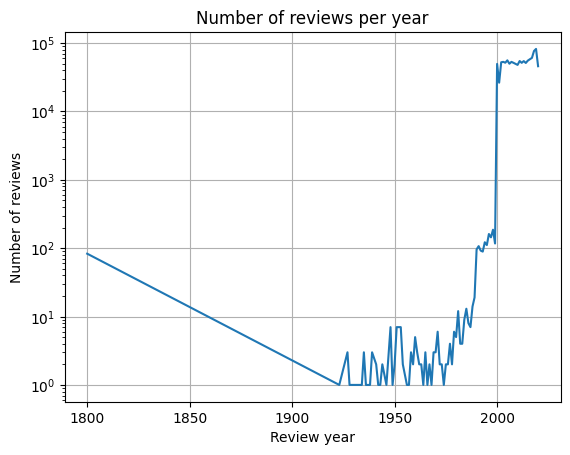

In [43]:
# Count the number of reviews per year
review_counts = rt_movies_with_reviews['review_date'].value_counts().sort_index()

# For a line graph
plt.plot(review_counts.index, review_counts.values)
plt.title('Number of reviews per year')
plt.xlabel('Review year')
plt.ylabel('Number of reviews')
plt.yscale('log')
plt.grid(True)
plt.show()

As we can see, some review dates are impossibly early. Since we don't know when the review was actually written, and our analysis is time-sensitive, we remove these reviews from the dataset.

In [44]:
# The review date must be at least the original release date
rt_movies_no_early = rt_movies_with_reviews[rt_movies_with_reviews['review_date'] >= rt_movies_with_reviews['original_release_date']].copy()
rt_movies_no_early

,rotten_tomatoes_link,review_type,review_content,review_date,movie_title,original_release_date
0,m/0814255,Fresh,A fantasy adventure that fuses Greek mythology...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
1,m/0814255,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
2,m/0814255,Fresh,With a top-notch cast and dazzling special eff...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
3,m/0814255,Fresh,Whether audiences will get behind The Lightnin...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
4,m/0814255,Rotten,What's really lacking in The Lightning Thief i...,2010.0,Percy Jackson & the Olympians: The Lightning T...,2010.0
...,...,...,...,...,...,...
1130012,m/zulu_dawn,Rotten,NaN,2005.0,Zulu Dawn,1979.0
1130013,m/zulu_dawn,Fresh,"Seen today, it's not only a startling indictme...",2007.0,Zulu Dawn,1979.0
1130014,m/zulu_dawn,Fresh,A rousing visual spectacle that's a prequel of...,2010.0,Zulu Dawn,1979.0
1130015,m/zulu_dawn,Rotten,"A simple two-act story: Prelude to war, and th...",2011.0,Zulu Dawn,1979.0


Next we investigate the number of reviews given to movies that were released in a particular year, regardless of when the review was written.

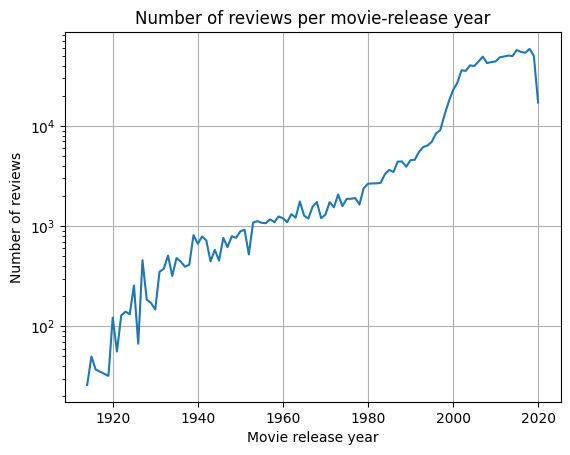

In [45]:
# Count the number of reviews per year
review_counts_movie_year = rt_movies_no_early['original_release_date'].value_counts().sort_index()

# Plotting

# For a line graph
plt.plot(review_counts_movie_year.index, review_counts_movie_year.values)

# For a bar chart (uncomment the next line and comment out the line graph line above)
# plt.bar(review_counts.index, review_counts.values)
plt.title('Number of reviews per movie-release year')
plt.xlabel('Movie release year')
plt.ylabel('Number of reviews')
plt.yscale('log')
plt.grid(True)
plt.show()

Finally, we look at the number of years between when movies were released and when the reviews were written.

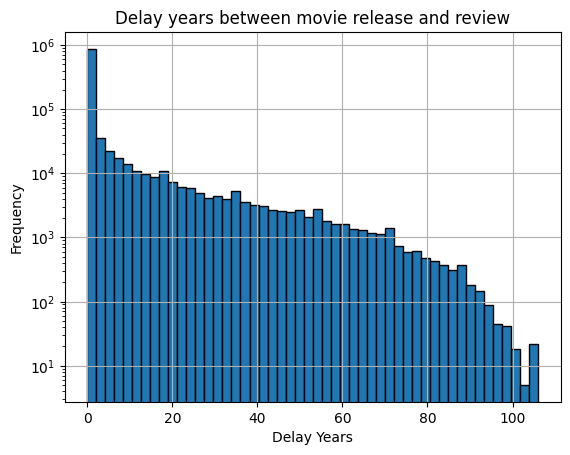

In [46]:
# Calculate the delay between review date and movie release date
rt_movies_no_early['delay'] = (rt_movies_no_early['review_date'] - rt_movies_no_early['original_release_date'])

# Plotting the histogram
plt.hist(rt_movies_no_early['delay'], bins=50, edgecolor='black')
plt.title('Delay years between movie release and review')
plt.xlabel('Delay Years')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

If these reviews are of any quality, we should make sure that if they exist, they are of a respectable length - seen in **number of words** and **number of sentences**.

In [47]:
# Filter out reviews with no text content
rt_movies_with_text = rt_movies_no_early[rt_movies_no_early['review_content'].notna()].copy()

In [48]:
# Exploratory Counts
rt_movies_with_text['word_count'] = rt_movies_with_text['review_content'].apply(word_count)
rt_movies_with_text['sentence_count'] = rt_movies_with_text['review_content'].apply(sentence_count)

Finally, we look at the number of movies for which we have both reviews **and** associated metadata.

In [49]:
create_combined_key

<function helpers.create_combined_key(title, date)>

In [50]:
# Applying the combined key function to both dataframes
movies_correct_dates['title_date_key'] = movies_correct_dates.apply(lambda x: create_combined_key(x['movie_name'], x['movie_release_date']), axis=1)
rt_movies_with_text['title_date_key'] = rt_movies_with_text.apply(lambda x: create_combined_key(x['movie_title'], x['original_release_date']), axis=1)

# Checking how many combined keys (title and date) are common between the two dataframes
common_title_date_keys_count = movies_correct_dates[movies_correct_dates['title_date_key'].isin(rt_movies_with_text['title_date_key'])].shape[0]
common_title_date_keys_count

8278

There are 8278 movies for which have reviews **and** metadata. 

In [51]:
# Merge metadata with Rotten Tomates reviews
movies_reviews = pd.merge(movies_correct_dates, rt_movies_with_text, left_on='title_date_key', right_on='title_date_key')
movies_reviews = movies_reviews[['movie_wikipedia_id', 'movie_freebase_id', 'movie_name', 'movie_release_date', 'genres', 'review_content', 'review_date']]
display(movies_reviews)

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,genres,review_content,review_date
0,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"[Musical, Comedy, Black-and-white]",Great fun.,2003.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"[Musical, Comedy, Black-and-white]","Easily a tune every few minutes, all reliably ...",2004.0
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"[Musical, Comedy, Black-and-white]","Despite Tyrone Powers' stiff turn in the lead,...",2008.0
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"[Musical, Comedy, Black-and-white]",Irving Berlin's Alexander's Ragtime Band is a ...,2009.0
4,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"[Musical, Comedy, Black-and-white]",28 of Irving Berlin's greatest songs make this...,2012.0
...,...,...,...,...,...,...,...
510921,34980460,/m/0g4pl34,Knuckle,2011.0,"[Biographical film, Drama, Documentary]",A time machine of ancient tradition spotlighti...,2011.0
510922,34980460,/m/0g4pl34,Knuckle,2011.0,"[Biographical film, Drama, Documentary]",An extraordinarily compelling and hard-hitting...,2012.0
510923,34980460,/m/0g4pl34,Knuckle,2011.0,"[Biographical film, Drama, Documentary]","A dark, brutal, black hole world of casual phy...",2012.0
510924,34980460,/m/0g4pl34,Knuckle,2011.0,"[Biographical film, Drama, Documentary]",Knuckle offers an intimate look at a largely u...,2012.0


Since we are only interested in reviews that are written in english, we use 'langdetect' to to find the language of each review and filter out those that are not written in english. As this process is quite long, we load the already filtered data.

In [52]:
DETECT_LANGUAGE = False

if DETECT_LANGUAGE:
    # Set seed for reproducibility in langdetect
    DetectorFactory.seed = 0

    # Function to detect language
    def detect_language(text):
        try:
            return detect(text)
        except LangDetectException:
            return "error"  # In case the text is too short or any other issue arises

    # Apply the language detection function to the review content
    movies_reviews['language'] = movies_reviews['review_content'].apply(detect_language)

    # Filter out non-English reviews
    final_reviews_df = movies_reviews[movies_reviews['language'] == 'en']
else:
    final_reviews_df = pd.read_csv('final_reviews.csv')

In [53]:
final_reviews_df

,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,genres,review_content,review_date,language
0,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"['Musical', 'Comedy', 'Black-and-white']","Easily a tune every few minutes, all reliably ...",2004.0,en
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"['Musical', 'Comedy', 'Black-and-white']","Despite Tyrone Powers' stiff turn in the lead,...",2008.0,en
2,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"['Musical', 'Comedy', 'Black-and-white']",Irving Berlin's Alexander's Ragtime Band is a ...,2009.0,en
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938.0,"['Musical', 'Comedy', 'Black-and-white']",28 of Irving Berlin's greatest songs make this...,2012.0,en
4,171005,/m/016ywb,Henry V,1989.0,"['Costume drama', 'War film', 'Epic', 'Period ...",One of the best film adaptations of Shakespeare.,2000.0,en
...,...,...,...,...,...,...,...,...
497289,34980460,/m/0g4pl34,Knuckle,2011.0,"['Biographical film', 'Drama', 'Documentary']",A time machine of ancient tradition spotlighti...,2011.0,en
497290,34980460,/m/0g4pl34,Knuckle,2011.0,"['Biographical film', 'Drama', 'Documentary']",An extraordinarily compelling and hard-hitting...,2012.0,en
497291,34980460,/m/0g4pl34,Knuckle,2011.0,"['Biographical film', 'Drama', 'Documentary']","A dark, brutal, black hole world of casual phy...",2012.0,en
497292,34980460,/m/0g4pl34,Knuckle,2011.0,"['Biographical film', 'Drama', 'Documentary']",Knuckle offers an intimate look at a largely u...,2012.0,en


## Data preprocessing  <a class="anchor" id="first"></a>

### Plot summaries preprocessing

In [54]:
tqdm.pandas() 
# Apply preprocessing on plots: Lowercasing, Removing special characters and numbers, Tokenization, Removing stopwords, Lemmatization
# This preprocessing step is important to have a clean text that eases future analysis
plot_summaries['preprocessed_text'] = plot_summaries['plot'].progress_apply(preprocess)
# Further plot cleaning by applying filters to remove words that do not make sense and keep only meaningful words
plot_summaries['clean_text'] = plot_summaries['preprocessed_text'].progress_apply(clean_sent_advanced)
# Get the sentences from plots
plot_summaries['sentence_tokens'] = plot_summaries['plot'].progress_apply(tokenize_sentences)
# Get the words from clean version plots
plot_summaries['word_tokens'] = plot_summaries['clean_text'].progress_apply(tokenize_words)

100%|██████████| 42303/42303 [00:14<00:00, 2901.49it/s]


In [55]:
# Add column that counts the number of sentences
plot_summaries['sentence_count'] = plot_summaries['sentence_tokens'].apply(len)

# Add column that counts the number of words
plot_summaries['word_count'] = plot_summaries['word_tokens'].apply(len)

In [56]:
plot_summaries['sentence_count'].describe()

count    42303.000000
mean        15.693071
std         16.605600
min          1.000000
25%          4.000000
50%          9.000000
75%         23.000000
max        344.000000
Name: sentence_count, dtype: float64

In [57]:
plot_summaries['word_count'].describe()

count    42303.000000
mean       146.877739
std        149.044434
min          1.000000
25%         42.000000
50%         89.000000
75%        214.000000
max       2205.000000
Name: word_count, dtype: float64

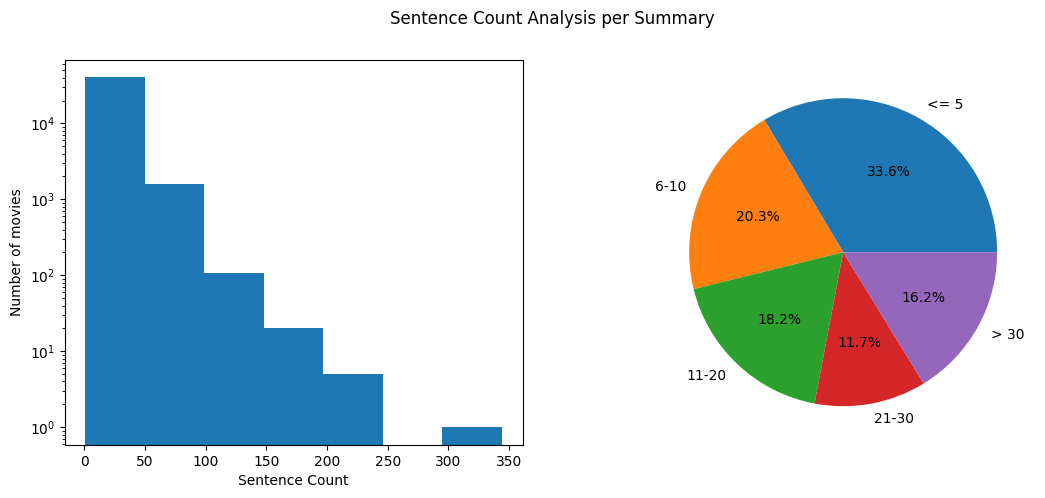

In [58]:
# Creating subplots for histogram and pie chart for sentence counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))

# Histogram for sentence counts
ax1.hist(plot_summaries['sentence_count'], bins=round(plot_summaries['sentence_count'].max()/50))
ax1.set_yscale('log')
ax1.set_ylabel('Number of movies')
ax1.set_xlabel('Sentence Count')

# Pie chart for sentence count ranges
ax2.pie([
    plot_summaries[plot_summaries['sentence_count'] <= 5].shape[0],
    plot_summaries[(plot_summaries['sentence_count'] > 5) & (plot_summaries['sentence_count'] <= 10)].shape[0],
    plot_summaries[(plot_summaries['sentence_count'] > 10) & (plot_summaries['sentence_count'] <= 20)].shape[0],
    plot_summaries[(plot_summaries['sentence_count'] > 20) & (plot_summaries['sentence_count'] <= 30)].shape[0],
    plot_summaries[plot_summaries['sentence_count'] > 30].shape[0]],
    labels=['<= 5', '6-10', '11-20', '21-30', '> 30'], autopct='%1.1f%%')

# Setting title for the entire figure
plt.suptitle('Sentence Count Analysis per Summary')
plt.show()

#### Plot summaries word count

We show that the word-counts follows a negative exponential distribution (y axis is in logarithmic scale). Most films have a short summary: most of them have a word-count below 500 words. In fact, nearly half of the dataset lies in the 100 to 500 words range. A very low percentage of films have a summary above 1000. Thus there might be a disparity in the precision of the plot due to the difference in length. Thus, longer plot summaries have higher chances of including multiple and more precise tech-related or event-related keywords.

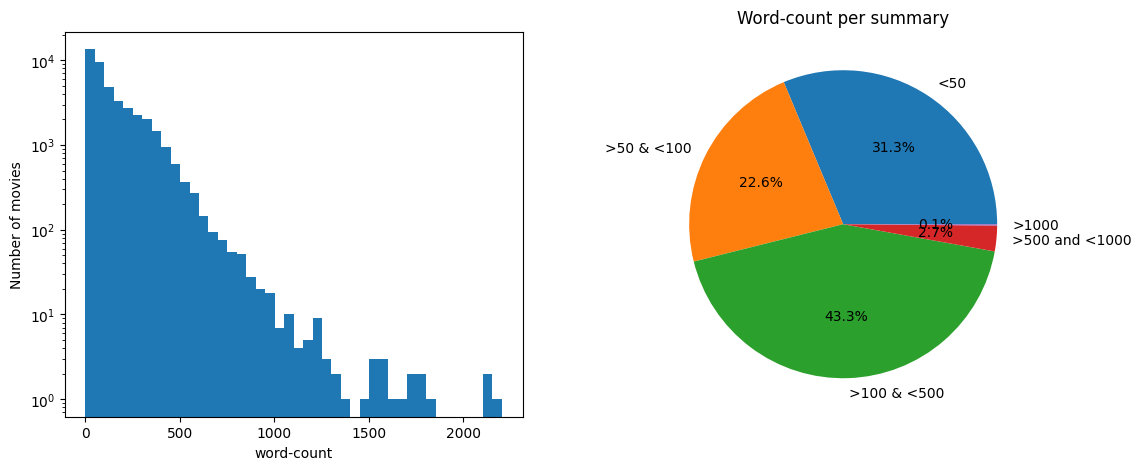

In [59]:
# Creating subplots for histogram and pie chart for word counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))

# Pie chart for word count ranges
ax2.pie([plot_summaries[plot_summaries['word_count'] <= 50].shape[0], plot_summaries[(plot_summaries['word_count'] > 50)&(plot_summaries['word_count'] <= 100)].shape[0], plot_summaries[(plot_summaries['word_count'] > 100)&(plot_summaries['word_count'] <= 500)].shape[0],
          plot_summaries[(plot_summaries['word_count'] > 500)&(plot_summaries['word_count'] <= 1000)].shape[0], plot_summaries[plot_summaries['word_count'] > 1000].shape[0]],
          labels = ['<50', '>50 & <100', '>100 & <500', '>500 and <1000', '>1000'], autopct='%1.1f%%')

# Histogram for word counts
ax1.hist(plot_summaries['word_count'], bins= round(plot_summaries['word_count'].max()/50))
ax1.set_yscale('log')
ax1.set_ylabel('Number of movies')
ax1.set_xlabel('word-count')
plt.title('Word-count per summary')
plt.show()

## Focus : Technology in real life <a class="anchor" id="third"></a>

### Lost movies <a class="anchor" id="third_a"></a>

#### Preprocessing and Merging

Many movies were lost across times, due to vault fires and usage of nitrate films. Let's have a look at an external database listing the most proeminent lost films in the USA (Wikidata). 

In [60]:
lost_movie_analysis_df = movies_correct_dates.copy()

In [61]:
# Load Lost movie data base
lost_movies_df = load_data_with_columns(DATAFOLDER, 'all_lost_films.csv')
lost_movies_df['Year'] = lost_movies_df['Year'].str.extract(r'(\d{4})').astype(float)
display(lost_movies_df)

,Year,Film,Director,Cast,Notes,Ref
0,1895.0,Young Griffo vs. Battling Charles Barnett,Otway Latham,"Young Griffo, Charles Barnett",First American film shown to a paying audience,NaN
1,1896.0,Arrivée d'un train gare de Vincennes,Georges Méliès,NaN,A French short documentary,NaN
2,1896.0,L'Arroseur (a.k.a. Watering the Flowers),Georges Méliès,NaN,A short comedy,NaN
3,1896.0,Barque sortant du port de Trouville,Georges Méliès,NaN,NaN,NaN
4,1896.0,Bateau-mouche sur la Seine,Georges Méliès,NaN,NaN,NaN
...,...,...,...,...,...,...
102,1977.0,Kissa Kursi Ka,Amrit Nahata,"Shabana Azmi, Utpal Dutt",The plot revolved around a corrupt and evil po...,NaN
103,1979.0,Njattadi,Bharath Gopi,"Bharat Murali, K.N. Sreenivasan, Sunil, Girija...",The film is based on the life of the protagoni...,NaN
104,1982.0,Milagro sa Porta Vaga,Florencio Orbeta,Julie Vega,Religious epic film about Our Lady of Porta Va...,NaN
105,1983.0,Roy del espacio,"Hector López Carmona, Rafael Ángel Gil and Uli...","José Chorena, Guillermo Coria, Juan Domingo Mé...",Animated Mexican sci-fi film. After its initia...,NaN


In [62]:
# Merge the lost movie database with our movie database
lost_merged_df = pd.merge(lost_movie_analysis_df, lost_movies_df, how='left', left_on='movie_name', right_on='Film', indicator=True)
lost_merged_df

# Add a new column "Lost" to MovieDF: 1 if a lost film, 0 otherwise 
# Also verifies if the release date is the same to avoid movies "remakes" with same names but released  much later 
# Takes into account NaN (0) in original database
lost_movie_analysis_df['Lost'] = ((lost_merged_df['_merge'] == 'both') & ((lost_merged_df['Year']== lost_merged_df['movie_release_date']) | (lost_merged_df['movie_release_date'] != 0))).astype(int)
lost_movie_analysis_df['Remakes'] = ((lost_merged_df['_merge'] == 'both') & (lost_merged_df['Year']!= lost_merged_df['movie_release_date']) & (lost_merged_df['movie_release_date'] != 0)).astype(int)

In [63]:
lost_films = lost_movie_analysis_df[lost_movie_analysis_df['Lost']==1]
print(lost_films.shape)
lost_films.head()

(92, 15)


,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres,movie_imdb_id,plot,movie_release_date_decade,title_date_key,Lost,Remakes
273,28327554,/m/0cnxf8t,The Gamblers,1970.0,NaN,93.0,[English Language],[United States of America],[Drama],NaN,NaN,1970.0,thegamblers_1970.0,1,1
3610,12272453,/m/02vygbp,Honky Tonk,1941.0,NaN,105.0,[English Language],[United States of America],"[Western, Black-and-white]",tt0033726,"Con man ""Candy"" Johnson and his friend ""Snipe...",1940.0,honkytonk_1941.0,1,1
4304,16326663,/m/03wgxy1,Paris,1926.0,NaN,67.0,[English Language],[United States of America],[Silent film],tt0017251,NaN,1920.0,paris_1926.0,1,1
5051,35712635,/m/0jt4mgg,The Love Racket,1929.0,NaN,74.0,[English Language],[United States of America],"[Crime Fiction, Drama]",tt0020113,NaN,1920.0,theloveracket_1929.0,1,0
5229,704961,/m/0347wx,Speakeasy,2002.0,NaN,86.0,[English Language],[United States of America],"[Drama, Indie]",NaN,NaN,2000.0,speakeasy_2002.0,1,1


48 movies of the database are now lost. These could be further analysed, for example by looking at actor careers that played in this movies to rediscover the lost and forgotten star of the past. 

In [64]:
remakes = lost_movie_analysis_df[lost_movie_analysis_df['Remakes']==1]
print(remakes.shape)
remakes.head()

(39, 15)


,movie_wikipedia_id,movie_freebase_id,movie_name,movie_release_date,box_office,runtime,languages,countries,genres,movie_imdb_id,plot,movie_release_date_decade,title_date_key,Lost,Remakes
273,28327554,/m/0cnxf8t,The Gamblers,1970.0,NaN,93.0,[English Language],[United States of America],[Drama],NaN,NaN,1970.0,thegamblers_1970.0,1,1
3610,12272453,/m/02vygbp,Honky Tonk,1941.0,NaN,105.0,[English Language],[United States of America],"[Western, Black-and-white]",tt0033726,"Con man ""Candy"" Johnson and his friend ""Snipe...",1940.0,honkytonk_1941.0,1,1
4304,16326663,/m/03wgxy1,Paris,1926.0,NaN,67.0,[English Language],[United States of America],[Silent film],tt0017251,NaN,1920.0,paris_1926.0,1,1
5229,704961,/m/0347wx,Speakeasy,2002.0,NaN,86.0,[English Language],[United States of America],"[Drama, Indie]",NaN,NaN,2000.0,speakeasy_2002.0,1,1
6924,10016800,/m/02pzxsq,Kissa Kursi Ka,1978.0,NaN,142.0,[Hindi Language],[India],[Drama],tt0311401,NaN,1970.0,kissakursika_1978.0,1,1


It is interesting to note that some films like "A Christmas Carol" or "Boys" were remade several times. More exploration on remakes could be made. It must be noted that it may be that movies are in the remake list because of an erroneous date in one of the two databases (like *Kissa Kursi Kaa* that has date 1977 and 1978 in the two databases.

#### Data visualization: Lost Movies

In [65]:
lost_stats_per_year = lost_movies_df.groupby(['Year'])['Year'].count()

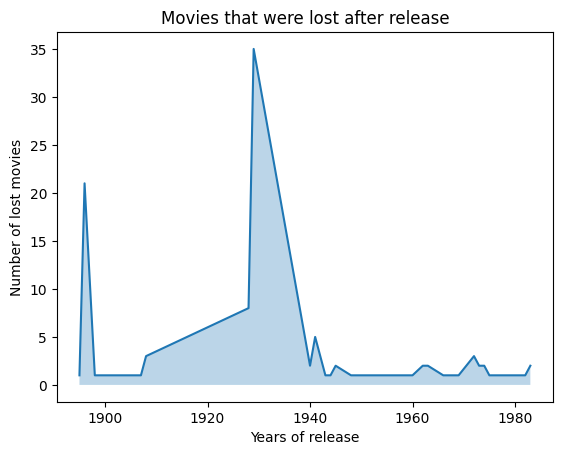

In [66]:
plt.plot(lost_stats_per_year.index.to_numpy(), lost_stats_per_year.values)
plt.fill_between(lost_stats_per_year.index.to_numpy(), lost_stats_per_year.values, alpha = 0.3)
plt.xlabel("Years of release")
plt.ylabel("Number of lost movies")
plt.title("Movies that were lost after release")
plt.show()

In [67]:
# Identify releasing years with more than five reported lossed movies
lost_stats_per_year.index[lost_stats_per_year.values >=5]

Index([1896.0, 1928.0, 1929.0, 1941.0], dtype='float64', name='Year')

In [68]:
print(lost_stats_per_year[lost_stats_per_year.index == 1896])
print(lost_stats_per_year[lost_stats_per_year.index == 1928])
print(lost_stats_per_year[lost_stats_per_year.index == 1929])
print(lost_stats_per_year[lost_stats_per_year.index == 1941])

Year
1896.0    21
Name: Year, dtype: int64
Year
1928.0    8
Name: Year, dtype: int64
Year
1929.0    35
Name: Year, dtype: int64
Year
1941.0    5
Name: Year, dtype: int64


Firstly, it is interesting to notice that there were two waves of loss, with respective peaks in 1896 and 1929. The second one could be explicated by the serie of vault fire in 1933, 1936 and 1937 that destroyed many movies. 
Secondly, it is also important to note that since 1983, no more lost movies were registered as lost, probably due to the apparition of new storage technology that are less vulnerable and from which copies are more easier made. 

### Silent & black and white films <a class="anchor" id="third_b"></a>

#### Data visualization: Silent films
Using the movies metadata, we should first need to make sure that the subset of silent films allows to perform an analysis of the transition from silent movies to synchronized score and sound films. For this purpose, we can plot the number of silent films released per year, and similarily the proportion of silent films per year, to observe a drastic decrease around 1930 correlating with the arrival of the technology.

In [69]:
# Copy of a dataframe for mute film analysis
mute_analysis_df = movies_correct_dates.copy()

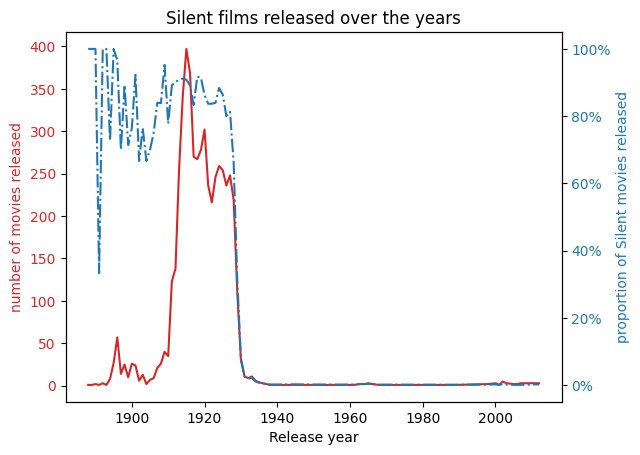

,frequency,total_nb_films
movie_release_date,,
1936.0,3,590
1900.0,26,34
2001.0,1,1402
1918.0,267,291
1908.0,26,31


In [70]:
#Dataframe grouping Silent films by year and indicating the number of silent films relased, as well as the total number of films released in that year
mute_films, mute_films_by_year = release_by_genre(mute_analysis_df)
plot_release_by_genre(mute_films_by_year)

#Display resulting dataframe
display(mute_films_by_year.sample(5))

#### Using a subset of actors that have starred in at least one silent film

For the analysis of the impact of the arrival of synchronized sound and score in movies on the actor's career, we need to use a subset of actors that have starred in at least one silent movie. We observe here the distribution of number of movies (silent or not) for each actor in that subset.
Notice that the data is heavy-tailed (both axes are in logarithmic scale). A lot of actors in the subset have released only a small number of movies.

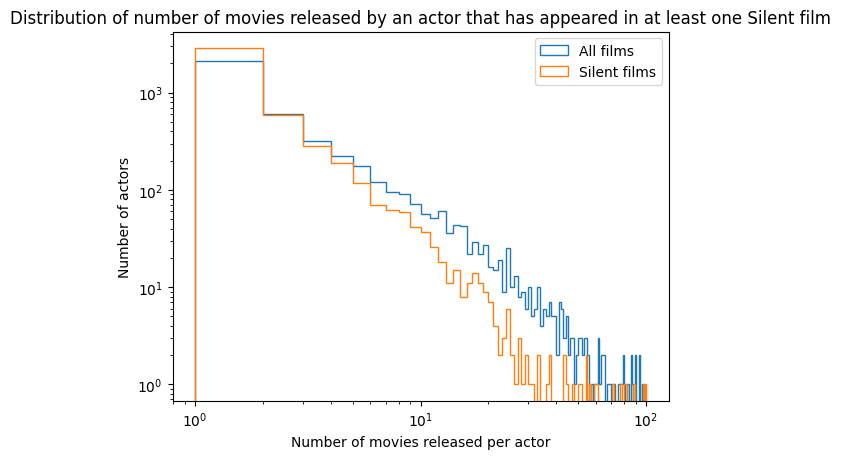

,birth_date,age_last_genre,Silent_appearances,non_Silent_appearances,total_appearances,nb_Silent_appearances,nb_non_Silent_appearances,nb_total_appearances,ratio
actor_name,,,,,,,,,
Cesarine Prinz\t,1883.0,39.0,[1922.0],[1926.0],"[1926.0, 1922.0]",1,1,2,1.0
'Big Bill' Giddinger,NaN,NaN,[1911.0],[],[1911.0],1,0,1,0.0
A. Arnold,NaN,NaN,[1929.0],[],[1929.0],1,0,1,0.0
A. B. Imeson,NaN,NaN,[1923.0],[],[1923.0],1,0,1,0.0
A. Bromley Davenport,1867.0,56.0,[1923.0],"[1933.0, 1938.0, 1931.0, 1932.0]","[1923.0, 1933.0, 1938.0, 1931.0, 1932.0]",1,4,5,4.0
...,...,...,...,...,...,...,...,...,...
Zoltán Szerémy,1861.0,57.0,"[1917.0, 1918.0]",[],"[1917.0, 1918.0]",2,0,2,0.0
rambaldo de goudron,NaN,NaN,[1915.0],[],[1915.0],1,0,1,0.0
Ángela Henao,NaN,NaN,[1925.0],[],[1925.0],1,0,1,0.0


In [71]:
#Character metadata grouped by acotrs, that have starred in at least one silent film 
characters_df = character_metadata.copy()
characters_df = characters_df[characters_df['movie_release_date'] > 1850]

#For each actor, we indicate the years the actor appears in a movie of the dataset
actors_silent = actors_by_genre(characters_df, mute_films)
plot_distrib_actors_by_genre(actors_silent)

#Display dataframe
display(actors_silent)

Similarly, we can visualize the distributions of the number of movies each of the silent film actors have appeared in. We can plot the distribution of number of silent films, non-silent films and all films per actor.
We can observe that the median of the middle distribution is at 0, meaning that at least half of the actors from the subset (ie. actors that have appeared in at least one silent film) have never acted in a non-silent film.

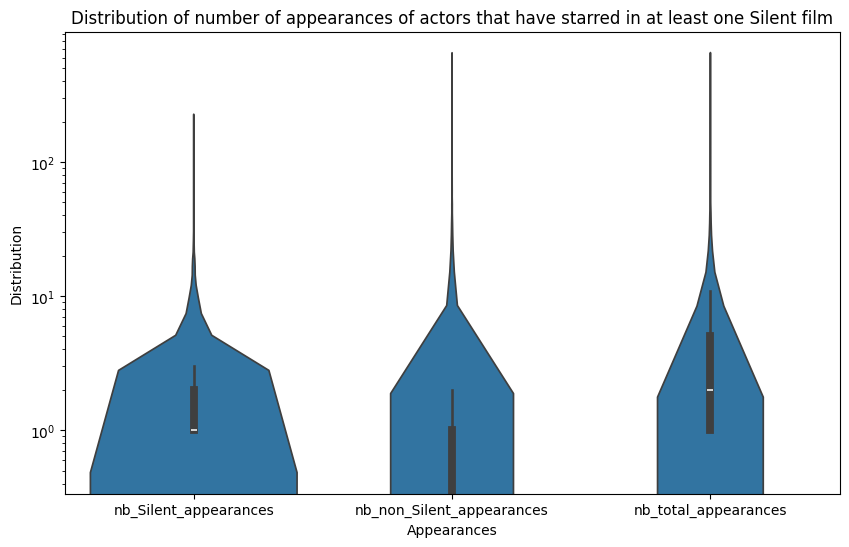

In [72]:
#Create dataframe suitable to plot violin plot for each column
genre = 'Silent'

df = pd.melt(actors_silent[['nb_{}_appearances'.format(genre), 'nb_non_{}_appearances'.format(genre), 'nb_total_appearances']].copy(), 
             var_name='Appearances', value_name='Distribution')

plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.violinplot(x='Appearances', y='Distribution', data=df)
plt.title('Distribution of number of appearances of actors that have starred in at least one Silent film')
plt.yscale('log')
plt.show()


#### Mean number of releases per actor

As a continuation, we can plot the mean number of movie releases across actors per year. This is done to see if there is a gradual decrease after the introduction of sound in the late 1920's. However there are a few things that are important to note:
- because our data is heavy-tailed, the use of the mean might not be the most appropriate choice, due to its sensitivity to extreme values. Using the median is not an alternative due to it being set to 0 all along. Similarly, the harmonic and geometric mean cannot deal with values set to 0.
- The death and retirement of these actors are a non-negligeable confounder of the decrease in activity after the introduction of sounds. For later analyses, we will in parallel observe the ages of each actor at the time of the transition to remove - to a certain degree- the confounder of death. Unfortunately we do not have the information relative to the actor's death in this dataset.

,count_silent,count_non_silent
actor_name,,
Cesarine Prinz\t,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
'Big Bill' Giddinger,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
A. Arnold,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
A. B. Imeson,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
A. Bromley Davenport,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
Zoltán Szerémy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
rambaldo de goudron,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Ángela Henao,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


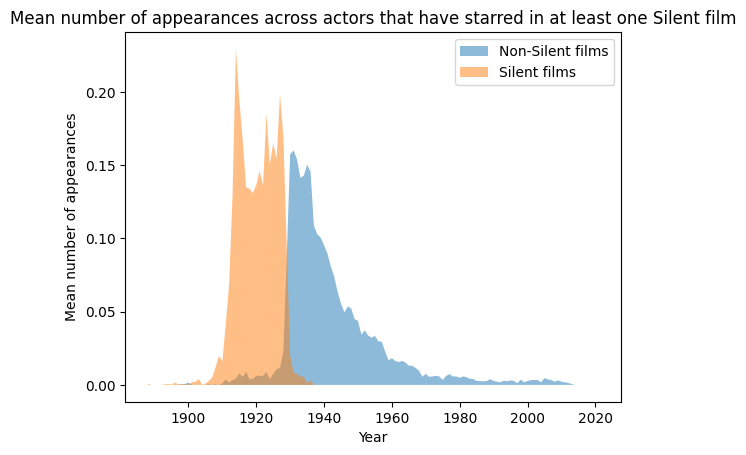

In [73]:
#Helper functions to create vector counting how many films the actor has appeared in for each year
def unique_years(x):
    years = []
    for year in x:
        if ~np.isin(year, years):
            years.append(year)
    return years
def count_per_year(x, range):
    years_appearance = unique_years(x)
    count = []
    for year in range:
        if np.isin(year, years_appearance):
            count.append(x.tolist().count(year))
        else:
            count.append(0)
    return np.asarray(count)

#range of years: 1888-2015
years = range(int(mute_analysis_df.movie_release_date.min()), int(mute_analysis_df.movie_release_date.max()))

# Create a new Dataframe containing the number of appearances of eah actor per year (1888-2015)
df_count_per_year = pd.DataFrame({'count_silent' : actors_silent['Silent_appearances'].copy().apply(lambda x : count_per_year(x, years)),
                       'count_non_silent' : actors_silent['non_Silent_appearances'].copy().apply(lambda x : count_per_year(x, years))})

#Display new dataframe
display(df_count_per_year)

#Plot the mean of appearances of actors per year
mean_silent_years = np.mean(np.stack(df_count_per_year.count_silent.values), axis = 0)
mean_non_silent_years = np.mean(np.stack(df_count_per_year.count_non_silent.values), axis = 0)

plt.fill_between(years, mean_non_silent_years, alpha = 0.5, label = 'Non-Silent films')
plt.fill_between(years, mean_silent_years, alpha = 0.5, label = 'Silent films')
plt.ylabel('Mean number of appearances')
plt.xlabel('Year')
plt.title('Mean number of appearances across actors that have starred in at least one Silent film')
plt.legend()
plt.show()


#### First Analysis : How many actors survived the "transition" from silent films to synchronized score and sound films?

We can now answer this question by using the ratio of non-Silent film releases over Silent film release for each actor. We have arbitrarily chosen that actors that have starred in as many non-silent films as silent films have  "survived" the transition. Any actor with a ratio below 1, we believe have not picked up their career after the transition in this first analysis. We have in parallel plotted the distributions of the age of the actor at their latest Silent film release.
- We can firstly see that majority of actors in the subset have not "survived that transition
- The average age of the actors at the time of their latest Silent film is around 40 years-old
- There is around 30% of missing data related to the age of the actors, which is non-negligeable and an obstacle to the analysis
- For further analyses, we could compute the same fractions but only for actors below 50 years old to limit the effect of the confounder of death and retirement.

Fraction of actors whose date of birth is missing: 33.64%
Fraction of actors whose age at latest Silent film is missing: 33.64% 

64.98% of actors that have starred in at least one silent film have not "survived" the arrival of synchrnized sound and scores in feature films.
The "survival" criterion is defined as such: if an actor has starred in at least as many non silent films as silent films, they have "survived" this transition. 



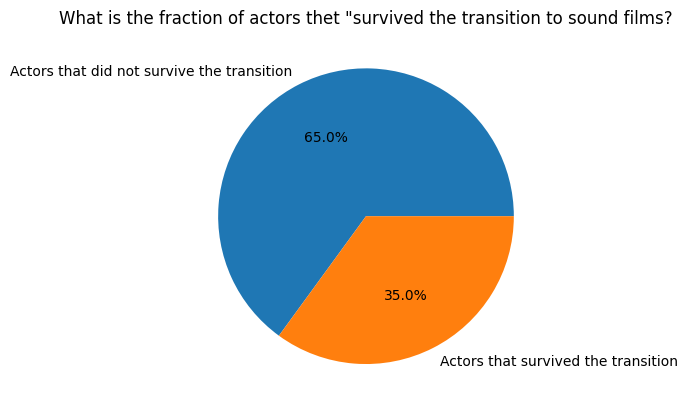

0.58% of actors are outliers: their age at latest silent film are below 0 or above 100 



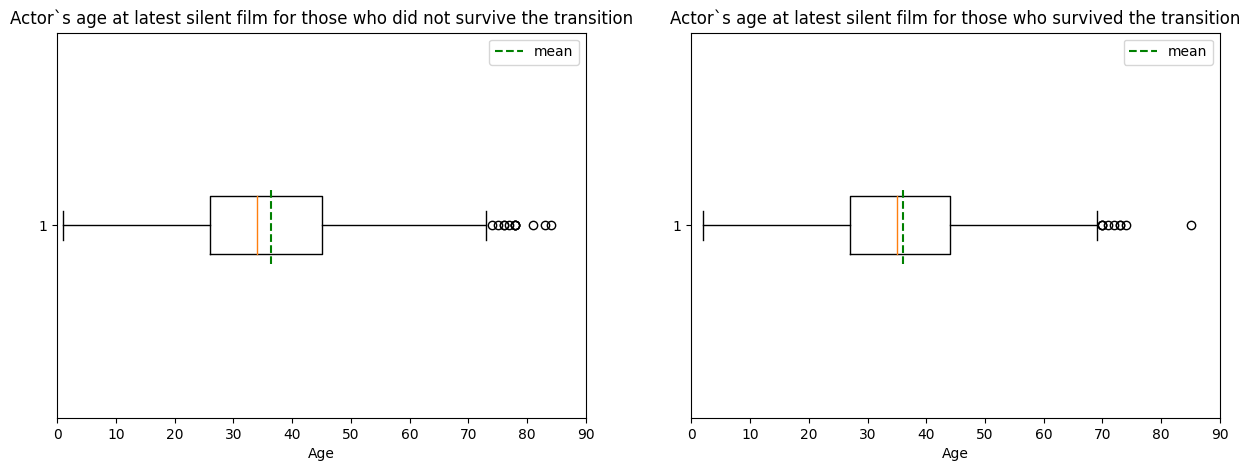

In [74]:
a = actors_silent['birth_date'].isna().sum()/actors_silent.shape[0]
b = actors_silent['age_last_genre'].isna().sum()/actors_silent.shape[0]

print('Fraction of actors whose date of birth is missing: {:.2%}'.format(a))
print('Fraction of actors whose age at latest Silent film is missing: {:.2%} \n'.format(b))

## Fraction of actors that "survived" transition
frac_min = 0.1
idx = actors_silent['ratio'].copy() <= frac_min
frac = idx.sum() / len(idx)

print('{:.2%} of actors that have starred in at least one silent film have not "survived" the arrival of synchrnized sound and scores in feature films.'.format(frac))
print('The "survival" criterion is defined as such: if an actor has starred in at least as many non silent films as silent films, they have "survived" this transition. \n')

#Pie chart
plt.pie([frac, 1-frac], labels = ['Actors that did not survive the transition', 'Actors that survived the transition'], autopct='%1.1f%%')
plt.title('What is the fraction of actors thet "survived the transition to sound films?')
plt.show()

## Average age of actors that "survived" transition
outliers = actors_silent[(actors_silent['age_last_genre'] <= 0) | (actors_silent['age_last_genre'] >= 100)].copy()
print('{:.2%} of actors are outliers: their age at latest silent film are below 0 or above 100 \n'.format(outliers.shape[0]/actors_silent.shape[0]))

actors_silent_filt = actors_silent[(actors_silent['age_last_genre'] > 0) & (actors_silent['age_last_genre'] < 100)].copy()

non_survivors = actors_silent_filt[actors_silent_filt['ratio'] <= frac_min].copy()
survivors = actors_silent_filt[actors_silent_filt['ratio'] >= frac_min].copy()

#Plot the age distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.boxplot(data= non_survivors, x = 'age_last_genre', vert=False)
ax1.vlines(non_survivors.age_last_genre.mean(), ymin = 0.9, ymax = 1.1, color = 'green', ls= '--', label = 'mean')
ax1.set_xlim(0, 90)
ax1.set_xlabel('Age')
ax1.set_title('Actor`s age at latest silent film for those who did not survive the transition')
ax1.legend()

ax2.boxplot(data= survivors, x = 'age_last_genre', vert=False)
ax2.vlines(survivors.age_last_genre.mean(), ymin = 0.9, ymax = 1.1, ls= '--', color = 'green', label = 'mean')
ax2.set_xlim(0, 90)
ax2.set_xlabel('Age')
ax2.set_title('Actor`s age at latest silent film for those who survived the transition')
ax2.legend()
plt.show()


#### Data visualization: Black-and-White films and Animated films
Using the movies metadata, we chould perform the same analysis for black-and-white films and the transition to colored films, and the increase of animated films with better animation technologies. However, from the first plot we can observe the following: 
- The proportion of balck-and-white films released over the years, we can see that the transition is much more progressive than synchrnized score and sound films,
- Although the number of animated films have increased over the years, its proportion has remained stable.

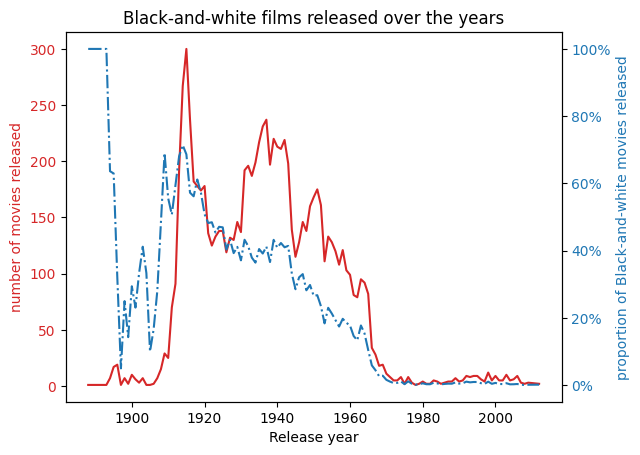

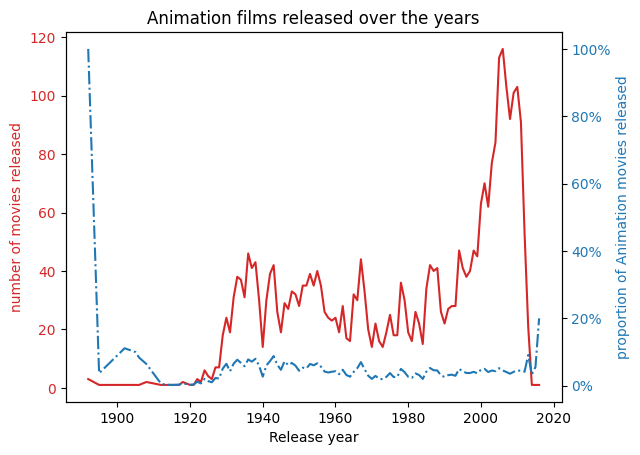

In [75]:
bw_films, bw_films_by_year = release_by_genre(mute_analysis_df, 'Black-and-white')
plot_release_by_genre(bw_films_by_year, 'Black-and-white')

anim_films, anim_films_by_year = release_by_genre(mute_analysis_df, 'Animation')
plot_release_by_genre(anim_films_by_year, 'Animation')

### Special effects <a class="anchor" id="third_c"></a>

Here we want to investigate the audience perception of known cinematography techniques.
We start by defining our techniques and then extracting the techniques mentioned in each movie review:

In [76]:
# Our list of techniques
techniques = [
    "cgi", "vfx", "special effects", "animation", "motion capture",
    " 3d ", " vr ", "stop motion", " ar ", "sound effect", "visual effect",
    "green screen", "digital compositing", "sound design",
    "virtual reality", "augmented reality"
]

# Pattern to match any of the techniques
pattern = '|'.join(techniques)

# Filtering the rows based on the review content containing the techniques
techniques_reviews = final_reviews_df[final_reviews_df['review_content'].str.lower().str.contains(pattern, regex=True)]

# Find a list of techniques for each review
techniques_reviews['technique_label'] = techniques_reviews['review_content'].apply(lambda x: find_techniques(x, techniques))

# Explode the DataFrame so each technique gets its own row
techniques_reviews_exploded = techniques_reviews.explode('technique_label')

/tmp/ipykernel_460588/2708244103.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  techniques_reviews['technique_label'] = techniques_reviews['review_content'].apply(lambda x: find_techniques(x, techniques))


Then we see how many each technique was mentioned in the reviews to select the few whose mentions size is significant enough for later analysis:

In [77]:
techniques_reviews_exploded.groupby('technique_label').size()

technique_label
 3d                 875
 vr                   1
animation          2562
cgi                1069
green screen          7
motion capture       26
sound design         73
sound effect         79
special effects    2340
stop motion          14
vfx                   7
virtual reality      33
visual effect       310
dtype: int64

In [78]:
# Subset of techniques we want to keep
selected_techniques = [" 3d ", "cgi", "animation", "special effects"]

# Filter the DataFrame
filtered_techniques_reviews = techniques_reviews_exploded[techniques_reviews_exploded['technique_label'].isin(selected_techniques)]

Now we come to the core function in our analysis: get_sentiment_score
In P2 we mentioned that VADER is used for sentiment analysis, however we noticed that using such a lexicon based method has very poor performance. 
To overcome this problem we use a pretrained Bert model for sentiment analysis, this model was pretrained on tweet text which is one of the closest text types we to movie reviews. This contextual based method is capable to capture complex context, and different tones (eg. sarcastic tones). 
Our second motive for this function was to find an approach that can target our technique word as we are not interested in the sentiment analysis on the review itself but rather on the part where the technique is mentioned. For this we use spacy to capture the tree of relationships between words within a sentence and get the part we are interested in. This approach was a very challenging one as the relationships between words and the formulations of the sentences are very complex to limit to one formula that can magically capture what we look for all the time. We conducted manual check with as much as possible reviews and we ended up with this implementation that though has flaws is still the most robust method we could find to answer our need for targeted contextual sentiment analysis.  

In [79]:
# Load the sentiment analysis pipeline with a specified model
sentiment_analyzer = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

# Load Spacy language model
nlp = spacy.load("en_core_web_sm")

def get_sentiment_score(sentence, keyword):
    # Process the sentence
    doc = nlp(sentence)

    # Function to find the span of the keyword phrase in the document
    def find_keyword_span(doc, keyword):
        keyword_tokens = keyword.lower().split()
        for i in range(len(doc) - len(keyword_tokens) + 1):
            if all(doc[i + j].text.lower() == keyword_tokens[j] for j in range(len(keyword_tokens))):
                return doc[i:i + len(keyword_tokens)]
        return None

    # Function logic for single-word keyword
    def get_broader_context_single(token, doc):
        sentence = next((sent for sent in doc.sents if token in sent), None)
        if not sentence:
            return ""
        # Search for the closest verb or auxiliary verb to the keyword
        closest_verb_or_aux = None
        for ancestor in token.ancestors:
            if ancestor.pos_ in ["VERB", "AUX"]:
                closest_verb_or_aux = ancestor
                break

        if closest_verb_or_aux:
            # Capture all tokens between the closest verb/auxiliary and the keyword
            start = min(closest_verb_or_aux.i, token.i)
            end = max(closest_verb_or_aux.i, token.i) + 1
            return doc[start:end].text
        else:
            # If no verb/auxiliary is found, return the closest adjective and its negation
            closest_adj = None
            for ancestor in token.ancestors:
                if ancestor.pos_ == "ADJ":
                    closest_adj = ancestor
                    break

            if closest_adj:
                # Check for negations or modifiers for the adjective
                negation = next((child for child in closest_adj.children if child.dep_ == "neg"), None)
                if negation:
                    start = min(closest_adj.i, negation.i, token.i)
                    end = max(closest_adj.i, negation.i, token.i) + 1
                else:
                    start = min(closest_adj.i, token.i)
                    end = max(closest_adj.i, token.i) + 1
                return doc[start:end].text
            else:
                return token.text

    # Function for multi-word keyword
    def get_broader_context_multi(span, doc):
        if not span:
            return ""
        
        # Extend the span to the nearest verb or auxiliary verb if possible
        start = span[0].i
        end = span[-1].i + 1

        for token in span:
            for ancestor in token.ancestors:
                if ancestor.pos_ in ["VERB", "AUX"]:
                    start = min(ancestor.i, start)
                    end = max(ancestor.i + 1, end)
                    break

        # Check for adjectives and their negations attached to tokens in the span
        for token in span:
            for child in token.children:
                if child.dep_ == 'amod':
                    start = min(child.i, start)
                    end = max(child.i + 1, end)
                    negation = next((neg for neg in child.children if neg.dep_ == "neg"), None)
                    if negation:
                        start = min(negation.i, start)

        return doc[start:end].text

    # Determine if the keyword is a single word or a phrase
    if " " in keyword:
        # Multi-word keyword
        keyword_span = find_keyword_span(doc, keyword)
        context_str = get_broader_context_multi(keyword_span, doc)
    else:
        # Single-word keyword
        context = None
        for token in doc:
            if token.text.lower() == keyword.lower():
                context = token
                break
        context_str = get_broader_context_single(context, doc) if context else ""

    # Sentiment analysis
    sentiment = sentiment_analyzer(context_str) if context_str else [{"label": "Neutral", "score": 0.5}]

    # Map sentiment label to a score
    label = sentiment[0]['label']
    score = sentiment[0]['score']
    if label == "POS":
        return score
    elif label == "NEG":
        return -score
    else:  # Neutral
        return (score-0.5)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Now let's find the sentiment score for each review. This takes time as well so it will be loaded directly.

In [124]:
tqdm.pandas()

GET_SCORE = False

if GET_SCORE: 
    # Apply the function to create the 'sentiment_score_technique' column
    filtered_techniques_reviews['sentiment_score_technique'] = filtered_techniques_reviews.progress_apply(
        lambda row: get_sentiment_score(row['review_content'], row['technique_label']), axis=1
    )
else:
    filtered_techniques_reviews = pd.read_csv(DATAFOLDER + 'filtered_techniques_reviews_saved.csv')

Here we want to explore the trend of the sentiment over the years for each technique:

In [125]:
techniques_data = filtered_techniques_reviews

# Extracting unique techniques
techniques = techniques_data['technique_label'].unique()

# Creating subplot figure with 2x2 layout
rows = cols = 2
fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=[t.capitalize() for t in techniques])

for i, technique in enumerate(techniques):
    # Grouping by release date and calculating average sentiment score for the technique
    technique_sentiment_trends_new = techniques_data[techniques_data['technique_label'] == technique].groupby('movie_release_date')['sentiment_score_technique'].mean()

    # Calculating the 5-year moving average
    moving_avg_sentiment_new = technique_sentiment_trends_new.rolling(window=5).mean()

    # Assigning subplot positions
    row = (i // cols) + 1
    col = (i % cols) + 1

    # Creating a plot for each technique
    plot = go.Scatter(x=moving_avg_sentiment_new.index, y=moving_avg_sentiment_new, mode='lines', name=f'{technique.capitalize()} Sentiment Scores')
    fig.add_trace(plot, row=row, col=col)

for i in range(1, 5):
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1

    # Update x-axis labels for the bottom row
    if row == 2:
        fig.update_xaxes(title_text='Release Year', row=row, col=col)

    # Update y-axis labels for the left column
    if col == 1:
        fig.update_yaxes(title_text='Sentiment Score', row=row, col=col)

fig.show()

In these plots we can see that there quiet many fluactations for most of the techniques over the years indicating that the public has received the techniques employed in movies differently with time.

Let's see also the distribution of scores per technique:

In [126]:
techniques_data = filtered_techniques_reviews  

# Create a violin plot 
fig = px.violin(techniques_data, x='technique_label', y='sentiment_score_technique',
                box=True,  
                title='Violin Plot of Sentiment Scores for Each Film Technique')

fig.update_xaxes(title_text='Film Technique')
fig.update_yaxes(title_text='Sentiment Score')
fig.show()

It is also worth investigating the scores per technique genre wise.
For this let's create the following heatmap:

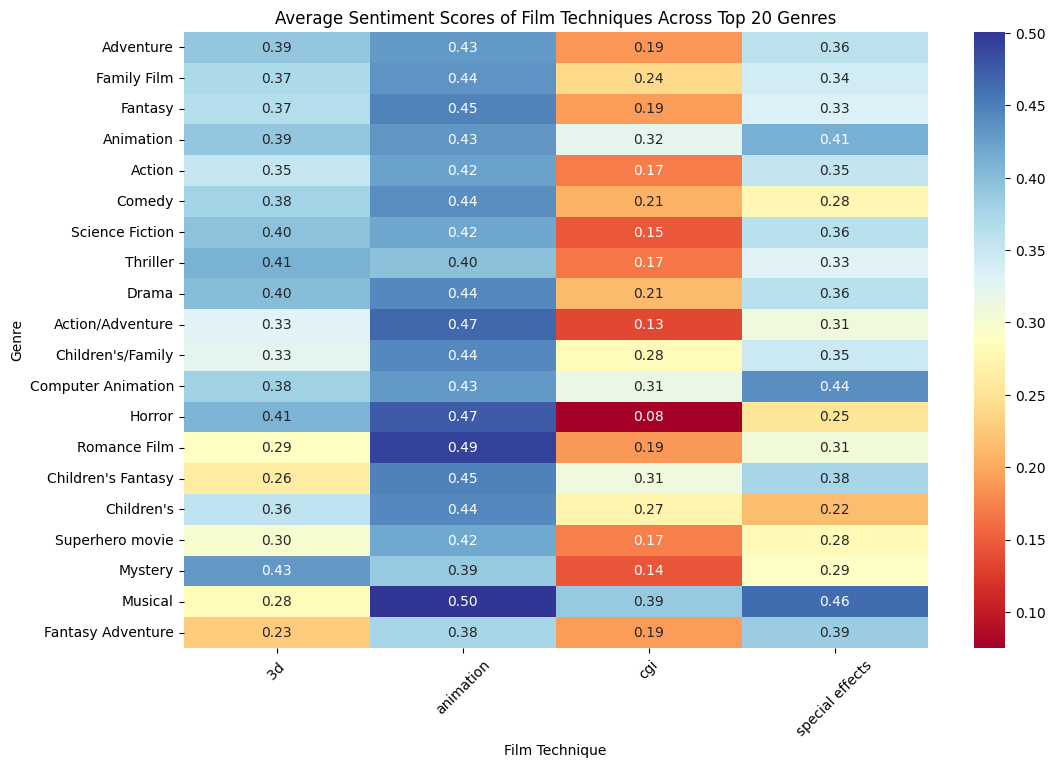

In [127]:
filtered_techniques_reviews['genres'] = filtered_techniques_reviews['genres'].apply(ast.literal_eval)

exploded_genres = filtered_techniques_reviews.explode('genres')

genre_technique_sentiment = exploded_genres.groupby(['genres', 'technique_label'])['sentiment_score_technique'].mean().unstack()

# Reducing the number of genres for better visualization by selecting the top genres with the most reviews
top_genres = exploded_genres['genres'].value_counts().nlargest(20).index
filtered_genre_technique_sentiment = genre_technique_sentiment.loc[top_genres]

# Plotting the modified heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_genre_technique_sentiment, annot=True, cmap='RdYlBu', fmt=".2f")
plt.title('Average Sentiment Scores of Film Techniques Across Top 20 Genres')
plt.xlabel('Film Technique')
plt.ylabel('Genre')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

We also show the same heatmap with the option to choose how many genres to be visualized in the heatmap:

In [128]:
def plot_heatmap(n_genres):
    # Selecting the top genres based on user input
    top_genres = exploded_genres['genres'].value_counts().nlargest(n_genres).index
    filtered_genre_technique_sentiment = genre_technique_sentiment.loc[top_genres]

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(filtered_genre_technique_sentiment, annot=True, cmap='RdYlBu', fmt=".2f")
    plt.title(f'Average Sentiment Scores of Film Techniques Across Top {n_genres} Genres')
    plt.xlabel('Film Technique')
    plt.ylabel('Genre')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Create a slider widget for the number of genres
genre_slider = widgets.IntSlider(
    value=20,
    min=1,
    max=len(exploded_genres['genres'].unique()),
    step=1,
    description='Number of Genres:',
    continuous_update=False
)

# Display the widget and the plot
widgets.interactive(plot_heatmap, n_genres=genre_slider)

interactive(children=(IntSlider(value=20, continuous_update=False, description='Number of Genres:', max=236, m…

Now we want to see if the audience reception to technique used in same movie change with time. For this we look for movies for which we have fresh reviews (less than 10 years old) and old ones (more than 10 years old). We ensure that the movie has a minimum of 7 for each category to ensure a reasonable analysis (more would be have been better but we are limited with the number of review we actually have).
This approach resulted in the following 4 movies. Let's see how their sentiment score evolve with time: 

In [85]:
# Calculating the delay for each review
techniques_data['review_delay'] = techniques_data['review_date'] - techniques_data['movie_release_date']

# Identifying movies with both conditions
movies_with_delays = techniques_data.groupby('movie_wikipedia_id').filter(
    lambda x: (x['review_delay'] >= 10).sum() >= 7 and (x['review_delay'] < 10).sum() >= 7
)['movie_name'].unique()

# Selecting the top 4 movies from this filtered list
top_4_delay_movies = pd.Series(movies_with_delays).value_counts().nlargest(4).index

# Creating subplots for each of the top 4 movies with mixed delays
fig = make_subplots(rows=2, cols=2, subplot_titles=top_4_delay_movies)

for i, movie in enumerate(top_4_delay_movies, 1):
    # Filtering data for the specific movie
    movie_data = techniques_data[techniques_data['movie_name'] == movie]

    # Smoothing the trend line using a rolling window
    rolling_window_size = 2  
    movie_data_grouped = movie_data.groupby('review_date')['sentiment_score_technique'].mean()
    smoothed_data = movie_data_grouped.rolling(rolling_window_size).mean()

    # Determine row and column for subplot
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1

    # Adding line plot to subplot
    fig.add_trace(go.Scatter(
        x=smoothed_data.index, 
        y=smoothed_data, 
        mode='lines+markers', 
        name=movie
    ), row=row, col=col)

    # Adding a vertical line for the movie release date
    release_date = movie_data['movie_release_date'].iloc[0]
    fig.add_vline(x=release_date, line_dash="dash", line_color="red", row=row, col=col)

    # Adding an annotation for the release date near the x-axis
    fig.add_annotation(
        x=release_date, 
        y=0,  
        text=f"{release_date}", 
        xref="x", yref="paper",  
        showarrow=False, 
        ax=0, ay=-40,  
        row=row, col=col
    )
    

# Updating layout for the figure
fig.update_layout(height=800, width=800, title_text="Sentiment Score Trends for Top 4 Movies with Mixed Delays")

for i in range(1, 7):
    row = (i - 1) // 2 + 1
    col = (i - 1) % 2 + 1

    # Update x-axis labels for the bottom row
    if row == 3:
        fig.update_xaxes(title_text='Review Year', row=row, col=col)

    # Update y-axis labels for the left column
    if col == 1:
        fig.update_yaxes(title_text='Sentiment Score', row=row, col=col)

# Show the figure
fig.show()

It is clear that the movie techniques are well received within the span of the few years after the movie release year (red vertical line) but they are less appreciated later on.

How about conducting a paired t-test to see the significance of what we just noticed ?
For this we ensure that we have two categories of reviews (old and fresh as mentioned before) and use the same sample size for the t-test.

In [86]:
# Function to perform a paired t-test with equal sample sizes
def perform_paired_ttest(movie_data):
    within_10_years = movie_data[movie_data['review_delay'] < 10]['sentiment_score_technique']
    more_than_10_years = movie_data[movie_data['review_delay'] >= 10]['sentiment_score_technique']
    # Equalizing sample sizes by random sampling
    min_size = min(len(within_10_years), len(more_than_10_years))

    within_10_years_sample = within_10_years.sample(min_size)
    more_than_10_years_sample = more_than_10_years.sample(min_size)

    t_statistic, p_value = ttest_rel(within_10_years_sample, more_than_10_years_sample, nan_policy='omit')
    return t_statistic, p_value

# Applying the tests for each movie
test_results = {
    'Paired T-Test': {}
}

for movie in top_4_delay_movies:
    movie_data = techniques_data[techniques_data['movie_name'] == movie]

    # Paired T-Test
    paired_t_statistic, paired_p_value = perform_paired_ttest(movie_data)
    test_results['Paired T-Test'][movie] = (paired_t_statistic, paired_p_value)
test_results

{'Paired T-Test': {'The Iron Giant': (1.074550649505115, 0.32387723672891605),
  'The Prince of Egypt': (2.3069432776975094, 0.054431370326226546),
  'Finding Nemo': (0.268257589451679, 0.7974855306797085),
  'Star Wars Episode I: The Phantom Menace': (2.6567166927476955,
   0.022317152993854936)}}

Let's visualize this:

In [87]:
import plotly.graph_objects as go

# Preparing the data for plotting
movies = []
statistics = []
p_values = []

for movie, values in test_results['Paired T-Test'].items():
    movies.append(movie)
    statistics.append(values[0])
    p_values.append(values[1])

# Creating the scatter plot
fig = go.Figure()

# Adding scatter plot for the paired T-test
fig.add_trace(go.Scatter(
    x=statistics, 
    y=p_values, 
    mode='markers+text', 
    text=movies, 
    name='Paired T-Test',
    textposition='top center'
))

# Adding significance line
fig.add_hline(y=0.05, line_dash="dash", line_color="red")

# Adding title and labels
fig.update_layout(
    title='Paired T-Test Results for Movies',
    xaxis_title='T-Statistic',
    yaxis_title='P-Value',
    legend_title='Test Type'
)

# Adding interactivity
fig.update_traces(marker=dict(size=12),
                  selector=dict(mode='markers+text'))

# Show the figure
fig.show()

We can that our observation is only significant for the movies 'The Prince of Egypt' and 'Star Wars Episode I: The Phantom Menace'

## Focus: Technology in movies <a class="anchor" id="fourth"></a>

### Movies about technology <a class="anchor" id="fourth_a"></a>

#### Extract tech-related movies <a class="anchor" id="fourth_a1"></a>

In [88]:
plot_summaries

,movie_wikipedia_id,plot,preprocessed_text,clean_text,sentence_tokens,word_tokens,sentence_count,word_count
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",shlykov hardworking taxi driver lyosha saxopho...,hardworking taxi driver saxophonist develop bi...,"[Shlykov, a hard-working taxi driver and Lyosh...","[hardworking, taxi, driver, saxophonist, devel...",1,11
1,31186339,The nation of Panem consists of a wealthy Capi...,nation panem consists wealthy capitol twelve p...,nation consists wealthy capitol twelve poorer ...,[The nation of Panem consists of a wealthy Cap...,"[nation, consists, wealthy, capitol, twelve, p...",52,367
2,20663735,Poovalli Induchoodan is sentenced for six yea...,poovalli induchoodan sentenced six year prison...,sentenced six year prison life murdering class...,[Poovalli Induchoodan is sentenced for six ye...,"[sentenced, six, year, prison, life, murdering...",26,200
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",lemon drop kid new york city swindler illegall...,lemon drop kid new york city swindler illegall...,"[The Lemon Drop Kid , a New York City swindler...","[lemon, drop, kid, new, york, city, swindler, ...",49,415
4,595909,Seventh-day Adventist Church pastor Michael Ch...,seventhday adventist church pastor michael cha...,adventist church pastor michael chamberlain wi...,[Seventh-day Adventist Church pastor Michael C...,"[adventist, church, pastor, michael, chamberla...",15,195
...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",story reema young muslim schoolgirl malabar lo...,story young muslim schoolgirl loved malayalam ...,"[The story is about Reema , a young Muslim sch...","[story, young, muslim, schoolgirl, loved, mala...",2,17
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",hollywood director leo andreyev look photograp...,hollywood director leo look photograph actor n...,"[In 1928 Hollywood, director Leo Andreyev loo...","[hollywood, director, leo, look, photograph, a...",31,239
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,american luthier focus randy parson transforma...,american luthier focus randy parson transforma...,[American Luthier focuses on Randy Parsons’ tr...,"[american, luthier, focus, randy, parson, tran...",6,71
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",abdur rehman khan middleaged dry fruit seller ...,khan dry fruit seller afghanistan come calcutt...,"[Abdur Rehman Khan , a middle-aged dry fruit s...","[khan, dry, fruit, seller, afghanistan, come, ...",10,108


We first start by grouping all words present in all summaries

In [89]:
# Combining and removing duplicates
combined_list = set()
for sublist in plot_summaries['word_tokens']:
    combined_list.update(sublist)

# Converting the set back to a list
combined_list = list(combined_list)
combined_list.sort()  # Optional: sorting the list
len(combined_list)

43301

We obtain an initial corpus of all meaningful words used in all plot summaries of size 43301

We then use the OpenAI API to extract only tech-related elements (words) present in the summaries word corpus. 

In [90]:
# Set API_CALL to True if we want to do the process from scratch but since it takes a lot of time we saved them in a file that we load directly 
API_CALL = False
if API_CALL: 
    # Set the API key using an environment variable
    # Personal Key
    os.environ['OPENAI_API_KEY'] = 'sk-soRRyNomoreCrediTSHaHA'

    # Initialize the OpenAI client
    client = OpenAI()

    # Function to process a single word
    def process_word(word):
        try:
            response = client.completions.create(
                model="text-davinci-003",  
                prompt="Is the word '" + word + "' technology related? Answer in yes or no only.",
                max_tokens=10  
            )
            return response.choices[0].text.strip()
        except Exception as e:
            print("Error processing word:", e)
            return None

    words_list = combined_list  

    result_words = []

    # Process each word in the list
    for word in tqdm(words_list, desc="Processing words"):
        result = process_word(word)
        if result and result.lower() in ['yes', 'no']:
            result_words.append((word, result))

    # Filtering the list to retrieve only the words with 'Yes' as tag, and excluding the tags from the result
    tech_words = [word for word, tag in result_words if tag == 'Yes']

else:
    tech_words =  pd.read_csv(DATAFOLDER + 'tech_words.csv')

To ensure we obtain more precise resutls we ran the same process on the previously obtained corpus of words with a slightly and more precise prompt.

In [91]:
# Set API_CALL to True if we want to do the process from scratch but since it takes a lot of time we saved them in a file that we load directly 
if API_CALL: 
    # Set the API key using an environment variable
    # Personal Key
    os.environ['OPENAI_API_KEY'] = 'sk-soRRyNomoreCrediTSHaHA'

    # Initialize the OpenAI client
    client = OpenAI()

    # Function to process a single word
    def process_word(word):
        try:
            response = client.completions.create(
                model="text-davinci-003",  # Adjust with the appropriate model
                prompt="Is the word '" + word + "'related to technological concept? Answer in yes or no only.",
                max_tokens=10  # Adjust as necessary
            )
            return response.choices[0].text.strip()
        except Exception as e:
            print("Error processing word:", e)
            return None

    reduced_result = []

    # Process each word in the list with a progress bar
    for word in tqdm(tech_words, desc="Processing words"):
        result = process_word(word)
        if result and result.lower() in ['yes', 'no']:
            reduced_result.append((word, result))

    # Filtering the list to retrieve only the words with 'Yes' as tag, and excluding the tags from the result
    reducted_tech_words = [word for word, tag in reduced_result if tag == 'Yes']

else:
    reducted_tech_words =  pd.read_csv(DATAFOLDER + 'reduce_tech_words.csv')

In [92]:
reducted_tech_words = reducted_tech_words.values.transpose().tolist()[0]

In [93]:
len(reducted_tech_words)

1940

We filter out non nouns words as we are only interested in nouns for further analysis (verbs, adjectives... do not reflect much the technology present in the plots)

In [94]:
# Tokenize and tag parts of speech
tagged_words = pos_tag(reducted_tech_words)

# Filter only nouns
tech_nouns = [word for word, pos in tagged_words if pos.startswith('NN')]

In [95]:
len(tech_nouns)

1071

In [96]:
plot_summaries

,movie_wikipedia_id,plot,preprocessed_text,clean_text,sentence_tokens,word_tokens,sentence_count,word_count
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",shlykov hardworking taxi driver lyosha saxopho...,hardworking taxi driver saxophonist develop bi...,"[Shlykov, a hard-working taxi driver and Lyosh...","[hardworking, taxi, driver, saxophonist, devel...",1,11
1,31186339,The nation of Panem consists of a wealthy Capi...,nation panem consists wealthy capitol twelve p...,nation consists wealthy capitol twelve poorer ...,[The nation of Panem consists of a wealthy Cap...,"[nation, consists, wealthy, capitol, twelve, p...",52,367
2,20663735,Poovalli Induchoodan is sentenced for six yea...,poovalli induchoodan sentenced six year prison...,sentenced six year prison life murdering class...,[Poovalli Induchoodan is sentenced for six ye...,"[sentenced, six, year, prison, life, murdering...",26,200
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",lemon drop kid new york city swindler illegall...,lemon drop kid new york city swindler illegall...,"[The Lemon Drop Kid , a New York City swindler...","[lemon, drop, kid, new, york, city, swindler, ...",49,415
4,595909,Seventh-day Adventist Church pastor Michael Ch...,seventhday adventist church pastor michael cha...,adventist church pastor michael chamberlain wi...,[Seventh-day Adventist Church pastor Michael C...,"[adventist, church, pastor, michael, chamberla...",15,195
...,...,...,...,...,...,...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho...",story reema young muslim schoolgirl malabar lo...,story young muslim schoolgirl loved malayalam ...,"[The story is about Reema , a young Muslim sch...","[story, young, muslim, schoolgirl, loved, mala...",2,17
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look...",hollywood director leo andreyev look photograp...,hollywood director leo look photograph actor n...,"[In 1928 Hollywood, director Leo Andreyev loo...","[hollywood, director, leo, look, photograph, a...",31,239
42300,35102018,American Luthier focuses on Randy Parsons’ tra...,american luthier focus randy parson transforma...,american luthier focus randy parson transforma...,[American Luthier focuses on Randy Parsons’ tr...,"[american, luthier, focus, randy, parson, tran...",6,71
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",abdur rehman khan middleaged dry fruit seller ...,khan dry fruit seller afghanistan come calcutt...,"[Abdur Rehman Khan , a middle-aged dry fruit s...","[khan, dry, fruit, seller, afghanistan, come, ...",10,108


In [97]:
# We count for each plot how many tech related words are used 
plot_summaries['tech_nouns_count'] = plot_summaries['word_tokens'].progress_apply(lambda x: count_matches(x, tech_nouns))

100%|██████████| 42303/42303 [00:40<00:00, 1044.70it/s]


In [98]:
# We get for each plot the tech related words  used
plot_summaries['tech_nouns_used'] = plot_summaries['word_tokens'].progress_apply(lambda x: get_matches(x, tech_nouns))

100%|██████████| 42303/42303 [00:37<00:00, 1122.83it/s]


In [99]:
# We get for each plot the most frequent tech noun
plot_summaries['most_frequent_tech_noun'] = plot_summaries['word_tokens'].progress_apply(lambda x: most_frequent_tech_noun(x, tech_nouns))

100%|██████████| 42303/42303 [00:42<00:00, 1001.57it/s]


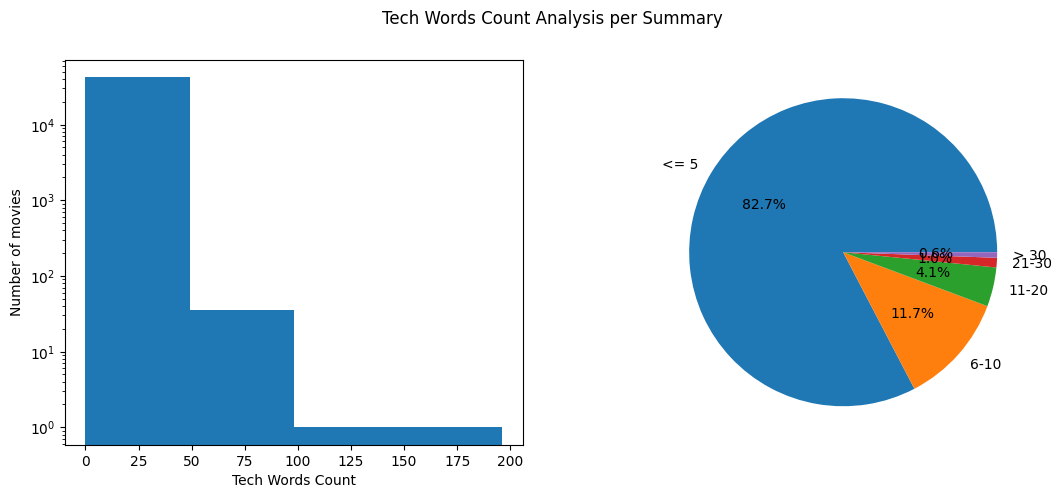

In [100]:
# Creating subplots for histogram and pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))

# Histogram for sentence counts
ax1.hist(plot_summaries['tech_nouns_count'], bins=round(plot_summaries['tech_nouns_count'].max()/50))
ax1.set_yscale('log')
ax1.set_ylabel('Number of movies')
ax1.set_xlabel('Tech Words Count')

# Pie chart for sentence count ranges
ax2.pie([
    plot_summaries[plot_summaries['tech_nouns_count'] < 5].shape[0],
    plot_summaries[(plot_summaries['tech_nouns_count'] >= 5) & (plot_summaries['tech_nouns_count'] <= 10)].shape[0],
    plot_summaries[(plot_summaries['tech_nouns_count'] > 10) & (plot_summaries['tech_nouns_count'] <= 20)].shape[0],
    plot_summaries[(plot_summaries['tech_nouns_count'] > 20) & (plot_summaries['tech_nouns_count'] <= 30)].shape[0],
    plot_summaries[plot_summaries['tech_nouns_count'] > 30].shape[0]],
    labels=['<= 5', '6-10', '11-20', '21-30', '> 30'], autopct='%1.1f%%')

# Setting title for the entire figure
plt.suptitle('Tech Words Count Analysis per Summary')
plt.show()

For future analysis, we can keep only plots containing 11+ tech-related words. To ensure that our movies are indeed technology related, we will also apply genre wise filtering where we use movies only of these genres: 

    "War film", "Epic", "Fantasy", "Children's Fantasy", "Crime Fiction",
    "Thriller", "Horror", "Psychological thriller", "Suspense", "Crime Thriller",
    "Adventure", "Action/Adventure", "World cinema", "Adventure Comedy", "Mystery",
    "Science Fiction", "Sci-Fi Horror", "Horror Comedy", "Superhero movie", "Wuxia",
    "Fantasy Adventure", "Martial Arts Film", "Dystopia", "Erotic thriller", "Slasher",
    "Zombie Film", "Sci-Fi Thriller", "Computer Animation", "Alien Film", "Superhero",
    "Creature Film", "Action Thrillers", "Cyberpunk", "Sci-Fi Adventure", "Space opera",
    "Apocalyptic and post-apocalyptic fiction", "Psychological horror", "Stop motion",
    "Animated Musical", "Animated cartoon", "Anime", "Nuclear warfare", "Gothic Film",
    "Space western", "Hybrid Western", "3D Animation", "Alien invasion", "Science fiction Western",
    "Splatter film", "Costume Horror", "CGI Animation", "Steampunk", "Adult Animation",
    "Virtual Reality", "High Fantasy", "Time Travel", "Futuristic", "Post-Apocalyptic",
    "Superhero Fiction", "Sci-Fi Fantasy", "Cyber Fantasy", "Utopian and dystopian fiction",
    "Virtual World", "Alternate Reality", "Mythological Fantasy", "Alien worlds"


In [101]:
unique_genres = final_reviews_df.drop_duplicates(subset='movie_wikipedia_id')[['movie_wikipedia_id', 'genres', 'movie_release_date']]
plot_summaries_filtered = plot_summaries[plot_summaries['tech_nouns_count'] >= 11]
# Merging the DataFrames to get the genre and movie release date
plot_summaries_with_genre = plot_summaries_filtered.merge(unique_genres, on='movie_wikipedia_id', how='left')

In [102]:
plot_summaries_with_genre

,movie_wikipedia_id,plot,preprocessed_text,clean_text,sentence_tokens,word_tokens,sentence_count,word_count,tech_nouns_count,tech_nouns_used,most_frequent_tech_noun,genres,movie_release_date
0,1838882,"The evil Lord Conqueror, head of Conqueror's C...",evil lord conqueror head conqueror clan given ...,evil lord conqueror head conqueror clan given ...,"[The evil Lord Conqueror, head of Conqueror's ...","[evil, lord, conqueror, head, conqueror, clan,...",21,193,17,[cloud],cloud,NaN,NaN
1,17711304,"In 1917, former newspaperman William Gordon e...",former newspaperman william gordon enlists u a...,former newspaperman enlists u army day leave w...,"[In 1917, former newspaperman William Gordon ...","[former, newspaperman, enlists, u, army, day, ...",29,239,11,"[alert, code, cryptography, information, secur...",code,NaN,NaN
2,18369853,Introduction: The usual chase starts for a few...,introduction usual chase start second stop lat...,introduction usual chase start second stop lat...,[Introduction: The usual chase starts for a fe...,"[introduction, usual, chase, start, second, st...",57,589,15,"[cloud, control, launch, pipeline, propeller, ...",cloud,NaN,NaN
3,4039635,A group of journalists are investigating a hig...,group journalist investigating highly secret d...,group journalist investigating highly secret d...,[A group of journalists are investigating a hi...,"[group, journalist, investigating, highly, sec...",15,185,19,"[contact, cosmonaut, document, footage, inform...",program,NaN,NaN
4,1520023,Ninja Resurrection takes place in the Tokugawa...,ninja resurrection take place tokugawa era tim...,ninja resurrection take place era time christi...,[Ninja Resurrection takes place in the Tokugaw...,"[ninja, resurrection, take, place, era, time, ...",192,1285,14,"[cloud, display, electricity, excel, extends, ...",cloud,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,5454803,"In the German Democratic Republic in 1984, se...",german democratic republic secret stasi office...,german democratic republic secret officer assi...,"[In the German Democratic Republic in 1984, s...","[german, democratic, republic, secret, officer...",47,408,24,"[alert, control, display, equipment, file, fin...",typewriter,"['Thriller', 'World cinema', 'Period piece', '...",2006.0
2405,1883373,The following is a detailed overview of the mi...,following detailed overview minimovies plot co...,following detailed overview plot considered mo...,[The following is a detailed overview of the m...,"[following, detailed, overview, plot, consider...",34,345,33,"[access, biplane, clone, component, control, e...",control,NaN,NaN
2406,1585815,The first half of the film is told in a non-co...,first half film told nonconsecutive narrative ...,first half film told narrative format introduc...,[The first half of the film is told in a non-c...,"[first, half, film, told, narrative, format, i...",57,449,12,"[camcorder, camera, console, format, motorcycl...",video,NaN,NaN
2407,871575,"{{Plot}} In an alternate universe, people are...",plot alternate universe people addicted illega...,plot alternate universe people addicted illega...,"[{{Plot}} In an alternate universe, people ar...","[plot, alternate, universe, people, addicted, ...",98,939,35,"[access, code, command, computer, convert, dat...",reset,NaN,NaN


In [103]:
print(plot_summaries_with_genre.isnull().sum())

movie_wikipedia_id            0
plot                          0
preprocessed_text             0
clean_text                    0
sentence_tokens               0
word_tokens                   0
sentence_count                0
word_count                    0
tech_nouns_count              0
tech_nouns_used               0
most_frequent_tech_noun       0
genres                     1401
movie_release_date         1401
dtype: int64


In [104]:
final_plot_summaries = plot_summaries_with_genre.dropna()

In [105]:
final_plot_summaries

,movie_wikipedia_id,plot,preprocessed_text,clean_text,sentence_tokens,word_tokens,sentence_count,word_count,tech_nouns_count,tech_nouns_used,most_frequent_tech_noun,genres,movie_release_date
5,6575053,"The crew of a deep ocean station ""DeepStar Six...",crew deep ocean station deepstar six funded na...,crew deep ocean station six funded navy expect...,"[The crew of a deep ocean station ""DeepStar Si...","[crew, deep, ocean, station, six, funded, navy...",37,339,21,"[airlock, carbon, command, computer, contact, ...",missile,"['Thriller', 'Natural horror films', 'Science ...",1989.0
8,4154028,The Facts in the Case of M. Valdemar Jessica V...,fact case valdemar jessica valdemar attractive...,fact case attractive woman ride taxi downtown ...,[The Facts in the Case of M. Valdemar Jessica ...,"[fact, case, attractive, woman, ride, taxi, do...",63,771,16,"[access, control, darkroom, detection, documen...",control,"['Thriller', 'Horror', 'Supernatural', 'Anthol...",1990.0
10,2322506,The film depicts a future in which human being...,film depicts future human being known oms crea...,film depicts future human being known creature...,[The film depicts a future in which human bein...,"[film, depicts, future, human, being, known, c...",60,591,21,"[adapt, cloud, device, disk, entity, frequency...",headset,"['Short Film', 'Science Fiction', 'Fantasy', '...",1973.0
13,19755481,"The film opens in a Montreal apartment, where ...",film open montreal apartment woman named lisa ...,film open montreal apartment woman named wait ...,"[The film opens in a Montreal apartment, where...","[film, open, montreal, apartment, woman, named...",47,493,20,"[chemical, fingerprint, flight, phone, plane, ...",phone,"['Thriller', 'Horror', 'Psychological thriller...",1967.0
14,26499399,{{Plot}} In the Dasht-E-Margoh desert in remot...,plot dashtemargoh desert remote afghanistan in...,plot desert remote afghanistan inside taliban ...,[{{Plot}} In the Dasht-E-Margoh desert in remo...,"[plot, desert, remote, afghanistan, inside, ta...",70,541,26,"[cell, detonate, detonator, device, flight, fu...",detonator,['Action'],2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390,12576807,{{Plot}} A month after the universe was ripped...,plot month universe ripped open futurama bende...,plot month universe ripped open bender big sco...,[{{Plot}} A month after the universe was rippe...,"[plot, month, universe, ripped, open, bender, ...",46,466,15,"[attach, contact, escalator, robot, version, v...",robot,"['Science Fiction', 'Comedy']",2008.0
2393,539816,The film depicts a future in which all plant l...,film depicts future plant life earth made exti...,film depicts future plant life earth made exti...,[The film depicts a future in which all plant ...,"[film, depicts, future, plant, life, earth, ma...",21,247,12,"[contact, drone, process, robot]",drone,"['Science Fiction', 'Adventure', 'Doomsday fil...",1972.0
2394,244610,{{plot}} A panicked scientist is running throu...,plot panicked scientist running swamp louisian...,plot panicked scientist running swamp louisian...,[{{plot}} A panicked scientist is running thro...,"[plot, panicked, scientist, running, swamp, lo...",52,612,24,"[contact, control, design, device, disk, edge,...",scientist,"['Science Fiction', 'Buddy film', 'Comedy West...",1999.0
2400,2486990,The film opens with Shaquille O'Neal and Dr. P...,film open shaquille oneal dr phil waking find ...,film open waking find ankle chained pipe spoof...,[The film opens with Shaquille O'Neal and Dr. ...,"[film, open, waking, find, ankle, chained, pip...",54,675,15,"[camera, command, destructive, device, motorbi...",tripod,"['Parody', 'Horror', 'Absurdism', 'Gross-out f...",2006.0


Now for every tech noun found in the plot we calculate its sentiment score:

In [106]:
PLOT_SCORES = False
if PLOT_SCORES:
    plot_summaries_with_scores = final_plot_summaries

    # Initialize a list to store the scores
    tech_nouns_scores_list = []

    for index, row in plot_summaries_with_scores.iterrows():
        sentence = row['plot']
        # Convert 'tech_nouns_used' to a list if it's a string
        tech_nouns = ast.literal_eval(row['tech_nouns_used']) if isinstance(row['tech_nouns_used'], str) else row['tech_nouns_used']
        scores = []
        for noun in tech_nouns:
            score = get_sentiment_score(sentence, noun)
            scores.append(score)
        
        # Add the scores list to the tech_nouns_scores_list
        tech_nouns_scores_list.append(scores)

        # Debugging output
        #print(f"Index: {index}, Scores: {scores}")

    # Assign the scores list to the DataFrame's new column
    plot_summaries_with_scores['tech_nouns_scores'] = tech_nouns_scores_list
else:
    plot_summaries_with_scores = pd.read_csv(DATAFOLDER + 'plot_summaries_with_scores.csv')

We calculate the average sentiment score for each plot:

In [107]:
# Calculate the average score for each plot using the scores of tech nouns

plot_summaries_with_scores['tech_score'] = plot_summaries_with_scores['tech_nouns_scores'].astype(str).apply(calculate_mean_from_string_list)

plot_summaries_with_scores.head()

,movie_wikipedia_id,plot,preprocessed_text,clean_text,sentence_tokens,word_tokens,sentence_count,word_count,tech_nouns_count,tech_nouns_used,most_frequent_tech_noun,genres,movie_release_date,tech_nouns_scores,tech_score
0,6575053,"The crew of a deep ocean station ""DeepStar Six...",crew deep ocean station deepstar six funded na...,crew deep ocean station six funded navy expect...,"['The crew of a deep ocean station ""DeepStar S...","['crew', 'deep', 'ocean', 'station', 'six', 'f...",37,339,21,"['airlock', 'carbon', 'command', 'computer', '...",missile,"['Thriller', 'Natural horror films', 'Science ...",1989.0,"[0.46484482288360596, 0.19891822338104248, 0.3...",0.114626
1,4154028,The Facts in the Case of M. Valdemar Jessica V...,fact case valdemar jessica valdemar attractive...,fact case attractive woman ride taxi downtown ...,['The Facts in the Case of M. Valdemar Jessica...,"['fact', 'case', 'attractive', 'woman', 'ride'...",63,771,16,"['access', 'control', 'darkroom', 'detection',...",control,"['Thriller', 'Horror', 'Supernatural', 'Anthol...",1990.0,"[0.4355318546295166, 0.2935525178909302, 0.460...",0.284145
2,2322506,The film depicts a future in which human being...,film depicts future human being known oms crea...,film depicts future human being known creature...,['The film depicts a future in which human bei...,"['film', 'depicts', 'future', 'human', 'being'...",60,591,21,"['adapt', 'cloud', 'device', 'disk', 'entity',...",headset,"['Short Film', 'Science Fiction', 'Fantasy', '...",1973.0,"[0.3513287901878357, 0.4445696473121643, 0.458...",0.334783
3,19755481,"The film opens in a Montreal apartment, where ...",film open montreal apartment woman named lisa ...,film open montreal apartment woman named wait ...,"['The film opens in a Montreal apartment, wher...","['film', 'open', 'montreal', 'apartment', 'wom...",47,493,20,"['chemical', 'fingerprint', 'flight', 'phone',...",phone,"['Thriller', 'Horror', 'Psychological thriller...",1967.0,"[0.42392539978027344, 0.0, 0.455744206905365, ...",0.296204
4,26499399,{{Plot}} In the Dasht-E-Margoh desert in remot...,plot dashtemargoh desert remote afghanistan in...,plot desert remote afghanistan inside taliban ...,['{{Plot}} In the Dasht-E-Margoh desert in rem...,"['plot', 'desert', 'remote', 'afghanistan', 'i...",70,541,26,"['cell', 'detonate', 'detonator', 'device', 'f...",detonator,['Action'],2012.0,"[0.4627920985221863, 0.3941243886947632, 0.449...",0.183410


In [108]:
# List of specific genres to focus on
selected_genres = [
    "War film", "Epic", "Fantasy", "Children's Fantasy", "Crime Fiction",
    "Thriller", "Horror", "Psychological thriller", "Suspense", "Crime Thriller",
    "Adventure", "Action/Adventure", "World cinema", "Adventure Comedy", "Mystery",
    "Science Fiction", "Sci-Fi Horror", "Horror Comedy", "Superhero movie", "Wuxia",
    "Fantasy Adventure", "Martial Arts Film", "Dystopia", "Erotic thriller", "Slasher",
    "Zombie Film", "Sci-Fi Thriller", "Computer Animation", "Alien Film", "Superhero",
    "Creature Film", "Action Thrillers", "Cyberpunk", "Sci-Fi Adventure", "Space opera",
    "Apocalyptic and post-apocalyptic fiction", "Psychological horror", "Stop motion",
    "Animated Musical", "Animated cartoon", "Anime", "Nuclear warfare", "Gothic Film",
    "Space western", "Hybrid Western", "3D Animation", "Alien invasion", "Science fiction Western",
    "Splatter film", "Costume Horror", "CGI Animation", "Steampunk", "Adult Animation",
    "Virtual Reality", "High Fantasy", "Time Travel", "Futuristic", "Post-Apocalyptic",
    "Superhero Fiction", "Sci-Fi Fantasy", "Cyber Fantasy", "Utopian and dystopian fiction",
    "Virtual World", "Alternate Reality", "Mythological Fantasy", "Alien worlds"
]

# Convert the string representation of list to actual list
plot_summaries_with_scores['genres'] = plot_summaries_with_scores['genres'].apply(ast.literal_eval)

# Expand the genres list into separate rows
genre_expanded_df = plot_summaries_with_scores.explode('genres')

# Filter the DataFrame for the selected genres
filtered_genre_df = genre_expanded_df[genre_expanded_df['genres'].isin(selected_genres)]

We plot the snetiment scores of plots over the years:

In [109]:
# Group by 'movie_release_date' and calculate the mean 'tech_score'
yearly_mean = plot_summaries_with_scores.groupby('movie_release_date')['tech_score'].mean()

# Calculate 5-year moving average of the mean 'tech_score'
moving_average = yearly_mean.rolling(window=10).mean()

# Create a Plotly figure
fig = go.Figure()

# Add a trace for the moving average
fig.add_trace(go.Scatter(x=moving_average.index, y=moving_average, mode='lines+markers', name='5-Year Moving Average'))
fig.update_xaxes(range=['1945', '2015'])
fig.update_yaxes(range=['-1', '1'])

# Update layout
fig.update_layout(title='Yearly Mean Sentiment Score and 5-Year Moving Average',
                  xaxis_title='Movie Release Year',
                  yaxis_title='Sentiment Score',
                  legend_title='Legend',
                  template='plotly_white')

# Show the plot
fig.show()

We see that it keeps a constant trend with quite neutral value. But is it the case genre wise ? Let's find out:

In [110]:
plot_summaries_with_scores = filtered_genre_df

# Extracting the top 4 genres
top_genres = plot_summaries_with_scores['genres'].value_counts().nlargest(4).index

# Creating a 2x2 subplot
fig = make_subplots(rows=2, cols=2, subplot_titles=top_genres)

# Row and column counters
row, col = 1, 1

# Loop through the top genres, filter data, and plot
for genre in top_genres:
    # Filter the dataframe for each genre
    genre_df = plot_summaries_with_scores[plot_summaries_with_scores['genres'] == genre]

    # Group by 'movie_release_date' and calculate the mean 'tech_score'
    yearly_mean = genre_df.groupby('movie_release_date')['tech_score'].mean()

    # Calculate 5-year moving average of the mean 'tech_score'
    moving_average = yearly_mean.rolling(window=5).mean()

    # Add a trace for each genre in the corresponding subplot
    fig.add_trace(go.Scatter(x=moving_average.index, y=moving_average, mode='lines+markers', name=f'{genre} Genre'), row=row, col=col)

    # Update axes titles for bottom row and left column only
    if row == 2:
        fig.update_xaxes(title_text='Movie Release Year', row=row, col=col)
    if col == 1:
        fig.update_yaxes(title_text='Sentiment Score', row=row, col=col)

    # Update row and column for the next subplot
    col += 1
    if col > 2:
        row += 1
        col = 1

# Update layout
fig.update_layout(title='Yearly Mean Sentiment Score and 5-Year Moving Average for Top 4 Genres',
                  #xaxis_title='Movie Release Year',
                  #yaxis_title='Tech Score',
                  legend_title='Genres',
                  template='plotly_white')

# Show the plot
fig.show()

Genre wise analysis shows that there quite interesting fluctations for sentiment score over the time.

Let's now see what are the most tech-related elements present in plots that are associated with most extreme values of sentiment scores accross plots.

In [111]:
# Parse each row and accumulate the scores and counts
word_scores = defaultdict(list)
word_counts = Counter()

for _, row in plot_summaries_with_scores.iterrows():
    for word, score in clean_and_parse(row):
        word_scores[word].append(score)
        word_counts[word] += 1

# Filter out words that were mentioned less than 20 times
filtered_word_scores = {word: scores for word, scores in word_scores.items() if word_counts[word] > 20}

# Calculate average score for each filtered word
average_filtered_scores = {word: sum(scores) / len(scores) for word, scores in filtered_word_scores.items()}

# Extract the most liked and least liked words (by average score) among those mentioned more than 5 times
most_liked_filtered = sorted(average_filtered_scores.items(), key=lambda x: x[1], reverse=True)[:10]
least_liked_filtered = sorted(average_filtered_scores.items(), key=lambda x: x[1])[:10]

most_liked_filtered, least_liked_filtered

([("'fusion'", 0.5071745241681734),
  ("'avatar'", 0.4905671454392947),
  ("'auto'", 0.48182272414366406),
  ("'inventor'", 0.4795615155907238),
  ("'translator'", 0.4564985930919647),
  ("'timeline'", 0.4542570511500041),
  ("'recorder'", 0.4519092670895837),
  ("'refinery'", 0.4510153972584268),
  ("'railway'", 0.44926488140354987),
  ("'transmits'", 0.4420178055763245)],
 [("'electrocution'", -0.7208209151313418),
  ("'destructive'", -0.7091381222009658),
  ("'malfunction'", -0.48770486017068226),
  ("'electricity'", -0.32977917075157165),
  ("'breach'", -0.3087102941104344),
  ("'virus'", -0.3009388001997079),
  ("'airliner'", -0.21544617606747535),
  ("'wrench'", -0.2109433737668124),
  ("'electronics'", -0.20535458759828049),
  ("'radiation'", -0.20274985128758)])

In [112]:
# Convert the most liked and least liked words to DataFrame for easy plotting
df_most_liked = pd.DataFrame(most_liked_filtered, columns=['Word', 'Average Score'])
df_least_liked = pd.DataFrame(least_liked_filtered, columns=['Word', 'Average Score'])


# Combining most liked and least liked words into a single DataFrame for interactive plotting
combined_df = pd.concat([df_most_liked, df_least_liked])

# Create an interactive bar plot using Plotly
fig = px.bar(combined_df, x='Word', y='Average Score', color='Average Score',
             labels={'Word': 'Word', 'Average Score': 'Average Score'},
             title='Top 10 Most and Least Liked Words')

# Show the interactive plot
fig.show()


#### Keyphrase analysis <a class="anchor" id="fourth_a2"></a>

A big portion of the work needed to analyze technologies in films and in the movie industry lies in the analysis of the move plot summaries. 
Technically, this analysis is done by extracting the useful words in the plots. 
Hence, in this section we:
1) Seperate the movie IDs from the plots as dictionaries
2) Use the NTLK library to tokenize the movie plots
3) Define a list of words to use for the search
4) Count the number of movies that contain at least 1 word in the given list per year
5) Plot the result in a graph

In [113]:
keyphrase_analysis_df = movies_correct_dates.copy()

In [114]:
# Read the plot summaries from the text file
with open(DATAFOLDER + 'plot_summaries.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

In [115]:
# Extract movie IDs and plot summaries and put them in separate lists.
movie_ids = []
plot_summaries_kp = []

for line in lines:
    parts = line.split('\t')
    if len(parts) == 2:
        movie_id, summary = parts
        movie_ids.append(int(movie_id))
        plot_summaries_kp.append(summary)

In [116]:
# Set stop words
stop_words = set(stopwords.words('english'))

# Tokenize and preprocess the plot summaries
tokenized_summaries = []
for summary in plot_summaries_kp:
    tokens = word_tokenize(summary)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    tokenized_summaries.extend(tokens)

KeyboardInterrupt: 

In [ ]:
# Define a list of technology-related keywords (to be modified at our convenience)
technology_keywords = ["computer", "computers","Computer", "Computers"]

# Create a dictionary to store film years based on movie IDs, with IDs as keys and movie plot summaries as values
film_years = {}
for index, row in keyphrase_analysis_df.iterrows():
    film_years[row['movie_wikipedia_id']] = row['movie_release_date']
    
# Initialize a dictionary to store the film counts per year
film_counts_by_year = {year: 0 for year in range(1900, 2015)}

# Count the occurrence of technology-related keywords
technology_word_counts = Counter(word for word in tokenized_summaries if word in technology_keywords)

In [ ]:
# Determine for which years films contain technology-related words and fill film_counts_by_year 
for movie_id in movie_ids:
    if movie_id in film_years:
        if ~np.isnan(film_years[movie_id]):
            year = int(film_years[movie_id])
            if year in film_counts_by_year:
                summary = plot_summaries_kp[movie_ids.index(movie_id)]
                if any(keyword in summary for keyword in technology_keywords):
                    film_counts_by_year[year] += 1

# Create a list of years and corresponding film counts
years = list(film_counts_by_year.keys())
film_counts = list(film_counts_by_year.values())

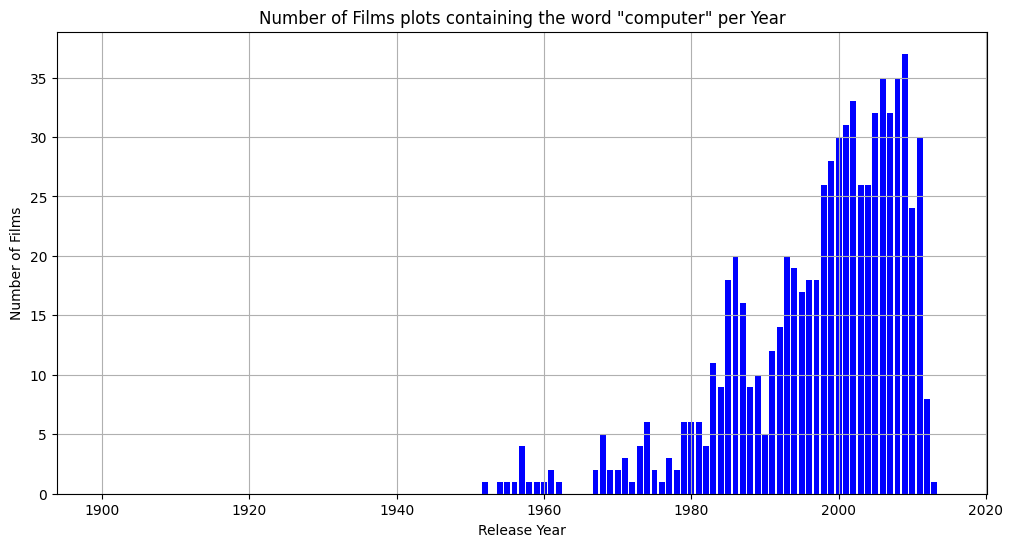

In [ ]:
# Plot the number of films containing technology-related words per year
plt.figure(figsize=(12, 6))
plt.bar(years, film_counts, color='b')
plt.title('Number of Films plots containing the word "computer" per Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Films')
plt.grid(True)
plt.show()


#### Technology adoption <a class="anchor" id="fourth_a3"></a>

We plan to compute the **mutual information** between technology adoption and specific keyphrase occurence in movie plots.

## Next steps <a class="anchor" id="fifth"></a>

This is space reserved for further ideas we explore in P3.